# 라이브러리

In [1]:
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from IPython.display import display
import numpy as np
from scipy.stats import zscore
import umap
import matplotlib.font_manager as fm
import warnings
import os
from tqdm import tqdm
from sklearn.mixture import GaussianMixture
from itertools import product
from sklearn.cluster import DBSCAN

C:\Users\user\anaconda3\envs\clustering_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\user\anaconda3\envs\clustering_env\lib\site-packages\umap\__init__.py:36: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


# 한글 설정

In [2]:
from matplotlib import rc

# 한글 폰트 설정
rc('font', family='Malgun Gothic')
# 마이너스 깨짐 방지
plt.rcParams['axes.unicode_minus'] = False

# Kmeans 클러스터링

### 최적의 클러스터 수 탐색

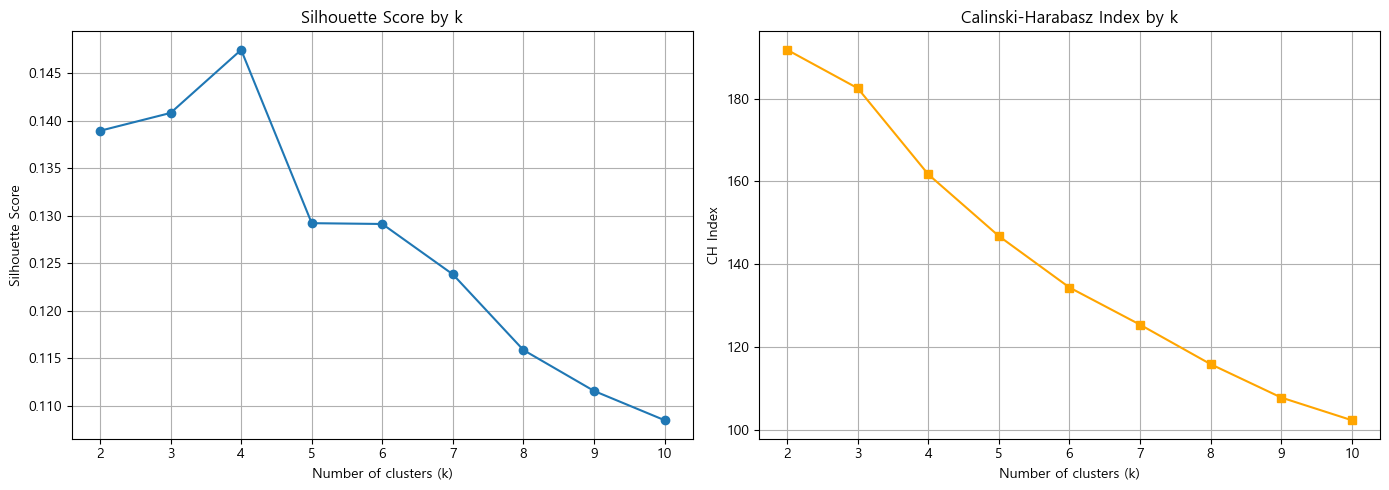

In [56]:
sil_scores = []
ch_scores = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    sil_scores.append(silhouette_score(X_scaled, labels))
    ch_scores.append(calinski_harabasz_score(X_scaled, labels))

# 시각화
plt.figure(figsize=(14, 5))

# Silhouette
plt.subplot(1, 2, 1)
plt.plot(k_range, sil_scores, marker='o')
plt.title("Silhouette Score by k")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Silhouette Score")
plt.grid(True)

# CH Index
plt.subplot(1, 2, 2)
plt.plot(k_range, ch_scores, marker='s', color='orange')
plt.title("Calinski-Harabasz Index by k")
plt.xlabel("Number of clusters (k)")
plt.ylabel("CH Index")
plt.grid(True)

plt.tight_layout()
plt.show()

| 기준            | 이유                                 |
| ------------- | ---------------------------------- |
| Silhouette 최고 | k=4                                |
| CH Index도 괜찮음 | k=4까지 양호                           |
| 해석 가능성        | 4개 정도가 실무에서 사용하기 적절 (마케팅 타겟 4군 정도) |


### NaN 값 제외 모든 변수 클러스터링(V1)

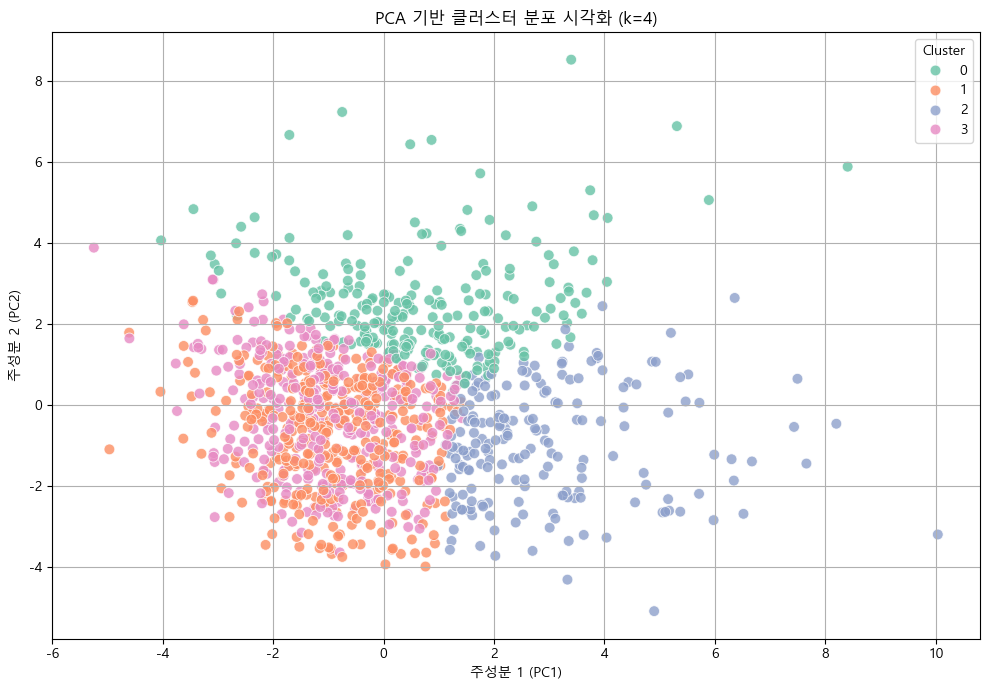

id current_age  Male Female per_capita_income  total_debt  \
cluster                                                                    
0        1,009.16       45.81  0.52   0.48         29,313.66  126,531.99   
1          965.28       55.19  0.00   1.00         19,593.45   38,812.43   
2        1,056.94       57.19  0.50   0.50         28,434.58   41,503.04   
3        1,003.20       52.95  1.00   0.00         19,222.62   42,417.25   

        credit_score num_credit_cards   tx_count   tx_amount tx_term  \
cluster                                                                
0             689.73             3.08  10,116.36  520,317.37    6.79   
1             717.96             3.82   9,274.57  343,906.78    7.23   
2             718.47             4.10  18,255.12  931,680.34    3.49   
3             720.64             3.77   9,426.72  331,564.40    7.33   

        online_tx_ratio  lifetime credit_usage_pct small_tx large_tx  \
cluster                                                                
0                  0.11  3,392.92             1.19    46.52    39.22   
1                  0.08  3,503.60             0.82    56.50    28.51   
2                  0.15  3,578.48             0.40    41.41    41.62   
3                  0.10  3,493.43             0.77    57.76    27.11   

        credit_risk repay_ability  region_avg  amount_diff  
cluster                                                     
0            184.22          2.22  487,856.61    32,460.73  
1             53.91          1.06  453,692.26  -109,785.48  
2             57.65          0.83  500,687.15   430,993.17  
3             59.05          1.15  445,175.22  -113,610.82


📈 클러스터링 평가지표:
• Silhouette Score           : 0.1188  (1에 가까울수록 좋음)
• Calinski-Harabasz Index    : 143.05   (클수록 좋음)
• Davies-Bouldin Index       : 2.0816  (작을수록 좋음)


In [53]:
# 1. 데이터 불러오기
df = pd.read_csv("clustering_filtered.csv")
df_cluster = df.drop(columns=['id', 'state_code'])

# 2. 결측치 처리
df_cluster['total_debt'] = df_cluster['total_debt'].fillna(df_cluster['total_debt'].mean())

# 3. 정규화
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_cluster)

# 4. KMeans 클러스터링 (k=4)
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
df['cluster'] = kmeans.fit_predict(X_scaled)

# 5. PCA로 2차원 축소
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# 6. 시각화용 DataFrame 구성
df_pca = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
df_pca['cluster'] = df['cluster']

# 7. 클러스터 분포 시각화
plt.figure(figsize=(10, 7))
sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='cluster', palette='Set2', s=60, alpha=0.8)
plt.title("PCA 기반 클러스터 분포 시각화 (k=4)")
plt.xlabel("주성분 1 (PC1)")
plt.ylabel("주성분 2 (PC2)")
plt.legend(title='Cluster')
plt.grid(True)
plt.tight_layout()
plt.show()

# 8. 클러스터별 평균 요약표 생성
cluster_summary = df.groupby('cluster').mean(numeric_only=True)

# 9. 포맷 적용 (천단위 콤마 + 소수점 2자리, applymap 경고 제거)
formatted_summary = cluster_summary.copy()
for col in formatted_summary.columns:
    formatted_summary[col] = formatted_summary[col].map(lambda x: f"{x:,.2f}")

# 10. 표 출력
display(formatted_summary)

# 11. 클러스터링 평가지표 출력
sil_score = silhouette_score(X_scaled, df['cluster'])
ch_score = calinski_harabasz_score(X_scaled, df['cluster'])
db_score = davies_bouldin_score(X_scaled, df['cluster'])

print("\n📈 클러스터링 평가지표:")
print(f"• Silhouette Score           : {sil_score:.4f}  (1에 가까울수록 좋음)")
print(f"• Calinski-Harabasz Index    : {ch_score:.2f}   (클수록 좋음)")
print(f"• Davies-Bouldin Index       : {db_score:.4f}  (작을수록 좋음)")

### 변수 최적화 후 클러스터링(V2)
| 변수명                              | 사유                                                |
| -------------------------------- | ------------------------------------------------- |
| `Female`                         | `Male`와 완전히 반대 정보 (중복)                            |
| `amount_diff`                    | `tx_amount`와 0.96 상관 (중복)                         |
| `small_tx`                       | `large_tx`와 -0.81 상관 (둘 중 하나만 사용)                 |
| `tx_count`                       | `tx_amount`와 0.72, `tx_term`과 -0.8 → **중복 정보 많음** |
| `credit_risk` 또는 `repay_ability` | 둘 다 비슷한 정보 제공 → **하나만 남기기**                       |  
- 해당 변수 제외 한 나머지 변수들러 클러스터링

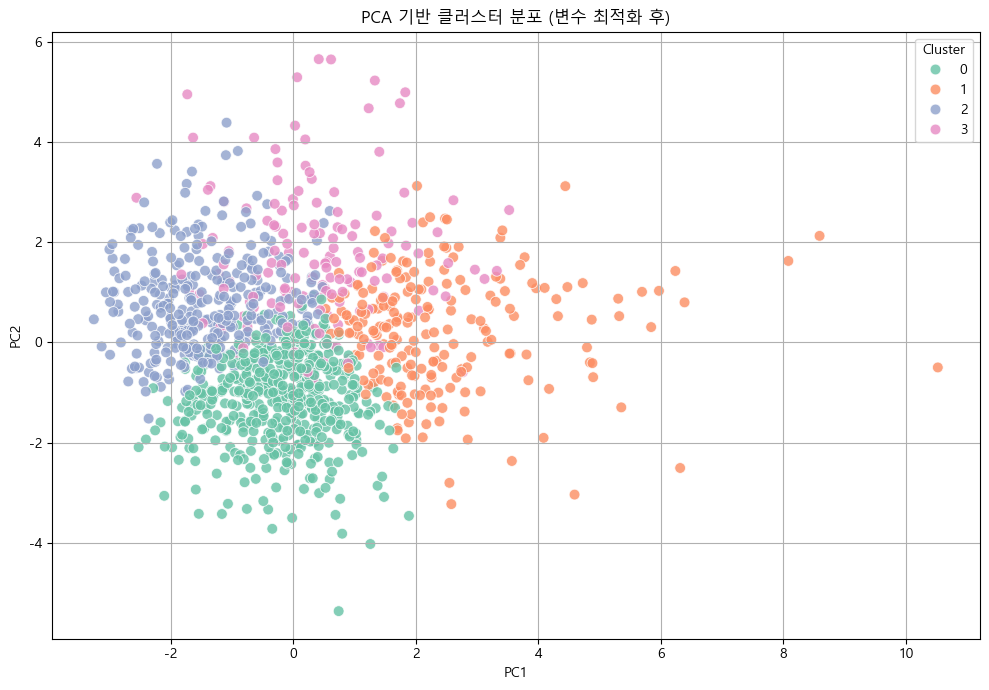

current_age  Male per_capita_income  total_debt credit_score  \
cluster                                                                
0             45.02  0.48         18,711.92   55,496.23       713.04   
1             46.96  0.57         32,411.60  128,840.20       699.09   
2             68.36  0.45         21,280.08   20,243.03       726.78   
3             54.29  0.51         26,076.37   44,940.67       705.18   

        num_credit_cards   tx_amount tx_term online_tx_ratio credit_risk  \
cluster                                                                    
0                   3.02  316,032.83    8.23            0.07       78.17   
1                   3.38  596,635.90    5.88            0.09      186.05   
2                   4.97  452,251.29    5.90            0.07       27.44   
3                   3.67  830,301.06    3.59            0.31       63.95   

         region_avg  
cluster              
0        435,664.89  
1        505,674.26  
2        470,941.51  
3        493,838.50


📈 클러스터링 평가지표:
• Silhouette Score           : 0.1355  (1에 가까울수록 좋음)
• Calinski-Harabasz Index    : 173.84   (클수록 좋음)
• Davies-Bouldin Index       : 1.9398  (작을수록 좋음)


In [48]:
# 1. 데이터 불러오기 및 변수 선택
df = pd.read_csv("clustering_filtered.csv")

# 사용할 변수 11개만 선택
selected_columns = [
    'current_age', 'Male', 'per_capita_income', 'total_debt', 'credit_score',
    'num_credit_cards', 'tx_amount', 'tx_term', 'online_tx_ratio',
    'credit_risk', 'region_avg'
]
df_cluster = df[selected_columns].copy()

# 2. 결측치 처리
df_cluster['total_debt'] = df_cluster['total_debt'].fillna(df_cluster['total_debt'].mean())

# 3. 정규화
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_cluster)

# 4. KMeans 클러스터링 (k=4)
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
df['cluster'] = kmeans.fit_predict(X_scaled)

# 5. PCA 시각화를 위한 차원 축소
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

df_pca = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
df_pca['cluster'] = df['cluster']

# 6. 시각화
plt.figure(figsize=(10, 7))
sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='cluster', palette='Set2', s=60, alpha=0.8)
plt.title("PCA 기반 클러스터 분포 (변수 최적화 후)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title="Cluster")
plt.grid(True)
plt.tight_layout()
plt.show()

# 7. 클러스터별 평균 요약표
cluster_summary = df.groupby('cluster')[selected_columns].mean()

# 보기 좋게 포맷팅 (천단위 콤마 + 소수점 2자리)
formatted_summary = cluster_summary.copy()
for col in formatted_summary.columns:
    formatted_summary[col] = formatted_summary[col].map(lambda x: f"{x:,.2f}")

display(formatted_summary)

# 8. 성능 평가지표 출력
sil_score = silhouette_score(X_scaled, df['cluster'])
ch_score = calinski_harabasz_score(X_scaled, df['cluster'])
db_score = davies_bouldin_score(X_scaled, df['cluster'])

print("\n📈 클러스터링 평가지표:")
print(f"• Silhouette Score           : {sil_score:.4f}  (1에 가까울수록 좋음)")
print(f"• Calinski-Harabasz Index    : {ch_score:.2f}   (클수록 좋음)")
print(f"• Davies-Bouldin Index       : {db_score:.4f}  (작을수록 좋음)")

### 변수 최적화 + 이상치 제거 후 클러스터링(V3)

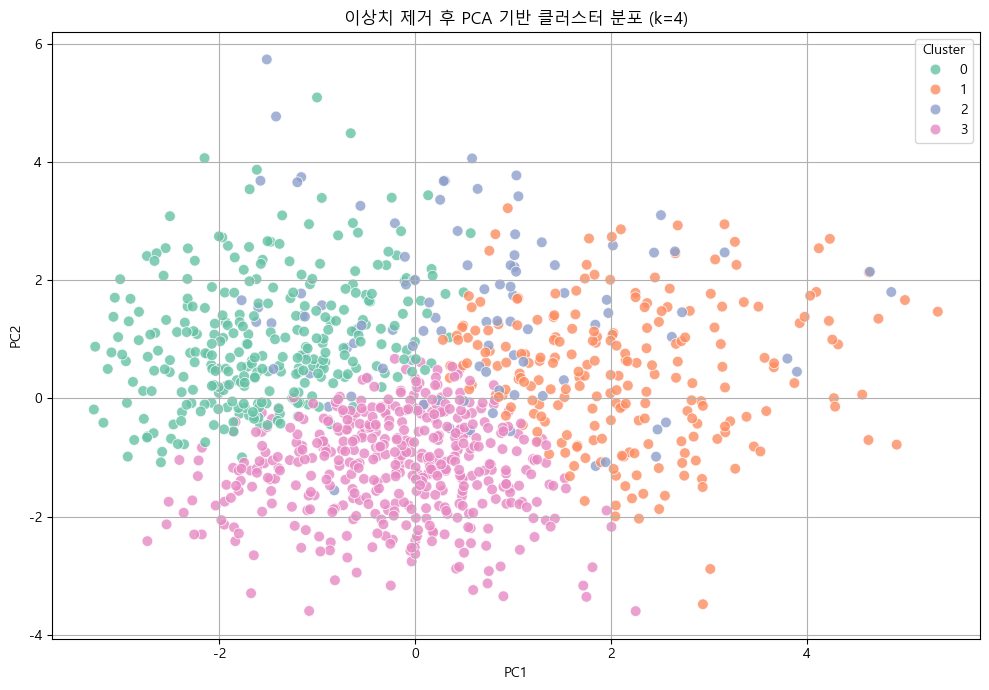

current_age  Male per_capita_income  total_debt credit_score  \
cluster                                                                
0             68.11  0.45         20,973.34   15,641.82       726.04   
1             47.72  0.53         28,789.95  108,591.55       705.68   
2             53.62  0.55         24,568.70   49,769.48       701.23   
3             45.75  0.47         18,393.14   54,213.94       718.98   

        num_credit_cards   tx_amount tx_term online_tx_ratio credit_risk  \
cluster                                                                    
0                   4.87  475,837.67    5.78            0.06       21.18   
1                   3.57  574,912.32    5.67            0.07      154.37   
2                   3.56  645,997.66    4.06            0.32       72.05   
3                   3.10  303,830.71    8.08            0.07       75.65   

         region_avg  
cluster              
0        470,372.21  
1        501,498.42  
2        473,515.04  
3        436,269.01


 클러스터링 평가지표 (이상치 제거 후):
• Silhouette Score           : 0.1475
• Calinski-Harabasz Index    : 161.69
• Davies-Bouldin Index       : 1.8701
• 데이터 수 감소: 1201 → 1074개 (제외: 127명)


In [55]:
# 1. 데이터 불러오기 및 변수 선택
df = pd.read_csv("clustering_filtered.csv")

selected_columns = [
    'current_age', 'Male', 'per_capita_income', 'total_debt', 'credit_score',
    'num_credit_cards', 'tx_amount', 'tx_term', 'online_tx_ratio',
    'credit_risk', 'region_avg'
]
df_cluster = df[selected_columns].copy()

# 2. 결측치 처리
df_cluster['total_debt'] = df_cluster['total_debt'].fillna(df_cluster['total_debt'].mean())

# 3. 이상치 제거 (z-score ±3 기준)
z_scores = np.abs(zscore(df_cluster))
outlier_mask = (z_scores < 3).all(axis=1)
df_cluster_filtered = df_cluster[outlier_mask].reset_index(drop=True)
df_filtered_raw = df[outlier_mask].reset_index(drop=True)

# 4. 정규화
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_cluster_filtered)

# 5. 클러스터링
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
df_filtered_raw['cluster'] = kmeans.fit_predict(X_scaled)

# 6. PCA 시각화
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
df_pca = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
df_pca['cluster'] = df_filtered_raw['cluster']

plt.figure(figsize=(10, 7))
sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='cluster', palette='Set2', s=60, alpha=0.8)
plt.title("이상치 제거 후 PCA 기반 클러스터 분포 (k=4)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()

# 7. 클러스터별 평균 요약표
cluster_summary = df_filtered_raw.groupby('cluster')[selected_columns].mean()

formatted_summary = cluster_summary.copy()
for col in formatted_summary.columns:
    formatted_summary[col] = formatted_summary[col].map(lambda x: f"{x:,.2f}")

display(formatted_summary)

# 8. 평가지표 출력
sil_score = silhouette_score(X_scaled, df_filtered_raw['cluster'])
ch_score = calinski_harabasz_score(X_scaled, df_filtered_raw['cluster'])
db_score = davies_bouldin_score(X_scaled, df_filtered_raw['cluster'])

print("\n 클러스터링 평가지표 (이상치 제거 후):")
print(f"• Silhouette Score           : {sil_score:.4f}")
print(f"• Calinski-Harabasz Index    : {ch_score:.2f}")
print(f"• Davies-Bouldin Index       : {db_score:.4f}")
print(f"• 데이터 수 감소: {len(df)} → {len(df_filtered_raw)}개 (제외: {len(df) - len(df_filtered_raw)}명)")

### 하이퍼 파라미터 자동 튜닝

In [63]:
# 데이터 로딩 및 전처리 (V2)
df = pd.read_csv("clustering_filtered.csv")
columns = [
    'current_age', 'Male', 'per_capita_income', 'total_debt', 'credit_score',
    'num_credit_cards', 'tx_amount', 'tx_term', 'online_tx_ratio',
    'credit_risk', 'region_avg'
]
df_cluster = df[columns].copy()
df_cluster['total_debt'] = df_cluster['total_debt'].fillna(df_cluster['total_debt'].mean())

# 정규화
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_cluster)

# 하이퍼파라미터 후보
init_methods = ['k-means++', 'random']                     # 2개
n_init_list = list(range(10, 210, 10))                     # 10 ~ 200 → 20개
max_iter_list = list(range(100, 1400, 100))                # 100 ~ 1300 → 13개

results = []

print("⏳ 총 조합 수:", len(init_methods) * len(n_init_list) * len(max_iter_list))

for init in tqdm(init_methods, desc="init"):
    for n_init in tqdm(n_init_list, desc="n_init", leave=False):
        for max_iter in max_iter_list:
            kmeans = KMeans(
                n_clusters=4,
                init=init,
                n_init=n_init,
                max_iter=max_iter,
                random_state=42
            )
            labels = kmeans.fit_predict(X_scaled)

            sil = silhouette_score(X_scaled, labels)
            ch = calinski_harabasz_score(X_scaled, labels)
            db = davies_bouldin_score(X_scaled, labels)

            results.append({
                'init': init,
                'n_init': n_init,
                'max_iter': max_iter,
                'Silhouette': sil,
                'CH': ch,
                'DB': db
            })

# 결과 정리
results_df = pd.DataFrame(results)
results_df_sorted = results_df.sort_values(by='Silhouette', ascending=False).reset_index(drop=True)

print("\n 상위 10개 성능 조합 (Silhouette 기준):")
display(results_df_sorted.head(10))

⏳ 총 조합 수: 520


init: 100%|██████████| 2/2 [05:22<00:00, 161.28s/it]   


✅ 상위 10개 성능 조합 (Silhouette 기준):


init  n_init  max_iter  Silhouette     CH   DB
0  random      10       100        0.15 175.68 1.85
1  random      10      1300        0.15 175.68 1.85
2  random      10       200        0.15 175.68 1.85
3  random      10       300        0.15 175.68 1.85
4  random      10       400        0.15 175.68 1.85
5  random      10       500        0.15 175.68 1.85
6  random      10       600        0.15 175.68 1.85
7  random      10       700        0.15 175.68 1.85
8  random      10       800        0.15 175.68 1.85
9  random      10       900        0.15 175.68 1.85

# GMM 클러스터링

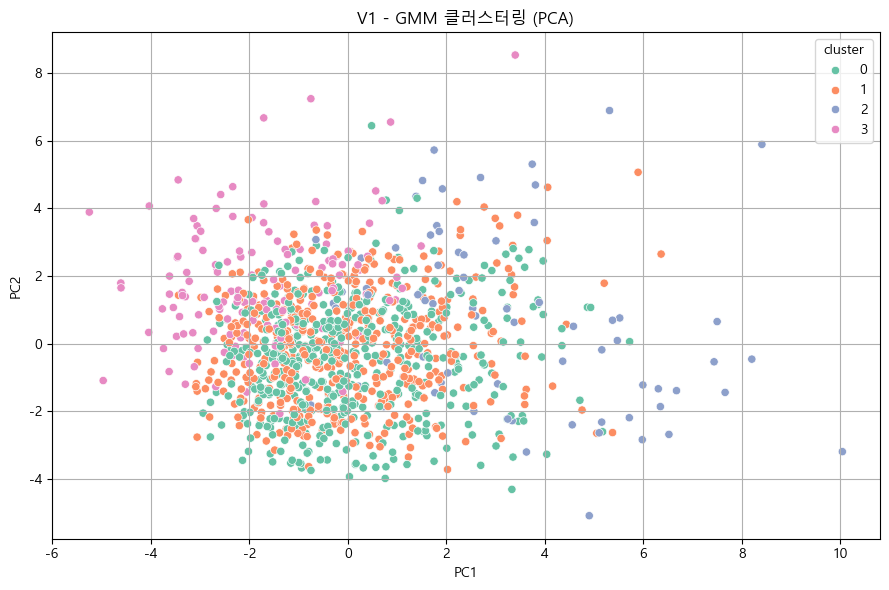

📊 V1 - 클러스터 요약


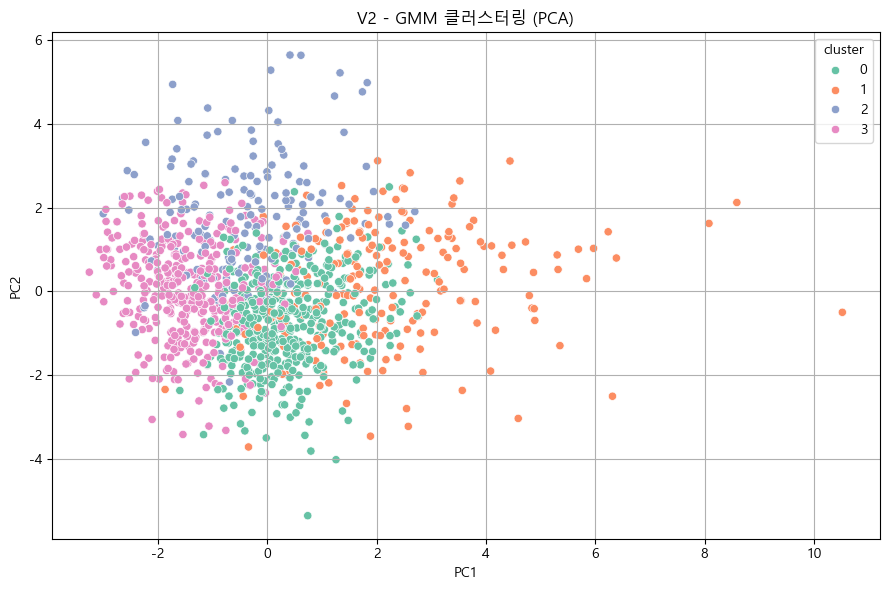

📊 V2 - 클러스터 요약


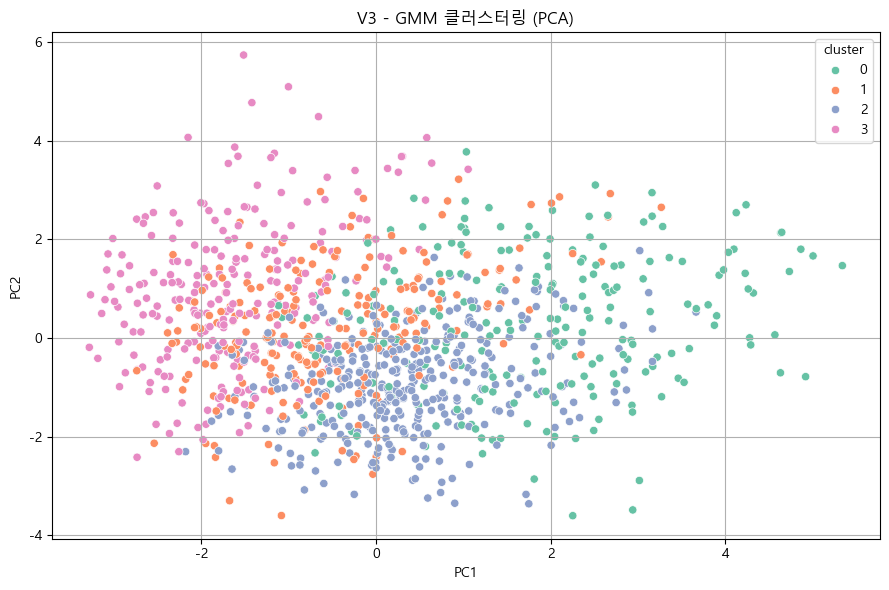

📊 V3 - 클러스터 요약


📈 GMM 성능 비교 (V1 ~ V3):


Version  Silhouette     CH   DB
0      V1        0.10  88.71 2.38
1      V2        0.07 119.78 2.52
2      V3        0.05  94.62 2.96

In [65]:
# 원본 데이터
df_raw = pd.read_csv("clustering_filtered.csv")

# 공통 설정
columns_v2 = [
    'current_age', 'Male', 'per_capita_income', 'total_debt', 'credit_score',
    'num_credit_cards', 'tx_amount', 'tx_term', 'online_tx_ratio',
    'credit_risk', 'region_avg'
]

versions = ['V1', 'V2', 'V3']
results = []

for version in versions:
    df = df_raw.copy()
    
    # 데이터 선택
    if version == 'V1':
        df_cluster = df.drop(columns=['id', 'state_code']).copy()
    else:
        df_cluster = df[columns_v2].copy()
    
    # 결측치 처리
    df_cluster['total_debt'] = df_cluster['total_debt'].fillna(df_cluster['total_debt'].mean())

    # 이상치 제거 (V3만)
    if version == 'V3':
        z_scores = np.abs(zscore(df_cluster))
        mask = (z_scores < 3).all(axis=1)
        df_cluster = df_cluster[mask].reset_index(drop=True)
        df = df[mask].reset_index(drop=True)

    # 정규화
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(df_cluster)

    # GMM 모델
    gmm = GaussianMixture(n_components=4, random_state=42)
    df['cluster'] = gmm.fit_predict(X_scaled)

    # 시각화 (PCA)
    X_pca = PCA(n_components=2).fit_transform(X_scaled)
    df_pca = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
    df_pca['cluster'] = df['cluster']

    plt.figure(figsize=(9, 6))
    sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='cluster', palette='Set2')
    plt.title(f"{version} - GMM 클러스터링 (PCA)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # 클러스터 요약
    if version == 'V1':
        summary = df.groupby('cluster').mean(numeric_only=True)
    else:
        summary = df.groupby('cluster')[columns_v2].mean()
    print(f"{version} - 클러스터 요약")
    display(summary.style.format("{:,.2f}"))

    # 성능 기록
    silhouette = silhouette_score(X_scaled, df['cluster'])
    ch_score = calinski_harabasz_score(X_scaled, df['cluster'])
    db_score = davies_bouldin_score(X_scaled, df['cluster'])

    results.append({
        'Version': version,
        'Silhouette': silhouette,
        'CH': ch_score,
        'DB': db_score
    })

# 결과 비교 출력
results_df = pd.DataFrame(results)
print("GMM 성능 비교 (V1 ~ V3):")
display(results_df.sort_values(by='Silhouette', ascending=False).reset_index(drop=True))


### 하이퍼 파라미터 자동 튜닝

In [66]:
# 원본 데이터
df_raw = pd.read_csv("clustering_filtered.csv")

# V2, V3 공통 변수
columns_v2 = [
    'current_age', 'Male', 'per_capita_income', 'total_debt', 'credit_score',
    'num_credit_cards', 'tx_amount', 'tx_term', 'online_tx_ratio',
    'credit_risk', 'region_avg'
]

# GMM 파라미터 후보
cov_types = ['full', 'tied', 'diag', 'spherical']
n_inits = [1, 2, 5, 10]
max_iters = [100, 200, 300, 500]
init_methods = ['kmeans', 'random']
param_grid = list(product(cov_types, n_inits, max_iters, init_methods))

results = []

for version in ['V1', 'V2', 'V3']:
    df = df_raw.copy()

    # 데이터 선택
    if version == 'V1':
        df_cluster = df.drop(columns=['id', 'state_code']).copy()
    else:
        df_cluster = df[columns_v2].copy()

    # 결측치 처리
    df_cluster['total_debt'] = df_cluster['total_debt'].fillna(df_cluster['total_debt'].mean())

    # 이상치 제거 (V3)
    if version == 'V3':
        z_scores = np.abs(zscore(df_cluster))
        mask = (z_scores < 3).all(axis=1)
        df_cluster = df_cluster[mask].reset_index(drop=True)
        df = df[mask].reset_index(drop=True)

    # 정규화
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(df_cluster)

    # GMM 파라미터 조합 루프
    print(f"\n{version} 단계에서 GMM 조합 테스트 중...")
    for cov, n_init, max_iter, init in tqdm(param_grid):
        try:
            gmm = GaussianMixture(
                n_components=4,
                covariance_type=cov,
                n_init=n_init,
                max_iter=max_iter,
                init_params=init,
                random_state=42
            )
            labels = gmm.fit_predict(X_scaled)

            sil = silhouette_score(X_scaled, labels)
            ch = calinski_harabasz_score(X_scaled, labels)
            db = davies_bouldin_score(X_scaled, labels)

            results.append({
                'Version': version,
                'cov_type': cov,
                'n_init': n_init,
                'max_iter': max_iter,
                'init_params': init,
                'Silhouette': sil,
                'CH': ch,
                'DB': db
            })
        except:
            continue  # 에러 무시

# 결과 정리
results_df = pd.DataFrame(results)
results_df_sorted = results_df.sort_values(by='Silhouette', ascending=False).reset_index(drop=True)

print("\nV1 ~ V3 전체 GMM 튜닝 결과 (Silhouette 기준 상위 10개)")
display(results_df_sorted.head(10))


🔍 V1 단계에서 GMM 조합 테스트 중...


100%|██████████| 128/128 [00:14<00:00,  9.09it/s]



🔍 V2 단계에서 GMM 조합 테스트 중...


100%|██████████| 128/128 [00:12<00:00, 10.45it/s]



🔍 V3 단계에서 GMM 조합 테스트 중...


100%|██████████| 128/128 [00:11<00:00, 11.50it/s]


📊 V1 ~ V3 전체 GMM 튜닝 결과 (Silhouette 기준 상위 10개)


Version   cov_type  n_init  max_iter init_params  Silhouette     CH   DB
0      V3  spherical       2       500      kmeans        0.15 158.85 1.87
1      V3  spherical       5       200      kmeans        0.15 158.85 1.87
2      V3  spherical      10       500      kmeans        0.15 158.85 1.87
3      V3  spherical      10       300      kmeans        0.15 158.85 1.87
4      V3  spherical       5       100      kmeans        0.15 158.85 1.87
5      V3  spherical      10       200      kmeans        0.15 158.85 1.87
6      V3  spherical       2       200      kmeans        0.15 158.85 1.87
7      V3  spherical      10       100      kmeans        0.15 158.85 1.87
8      V3  spherical       2       300      kmeans        0.15 158.85 1.87
9      V3  spherical       5       500      kmeans        0.15 158.85 1.87

# PCA 3차원 축소 Kmeans

📊 PCA + KMeans 결과


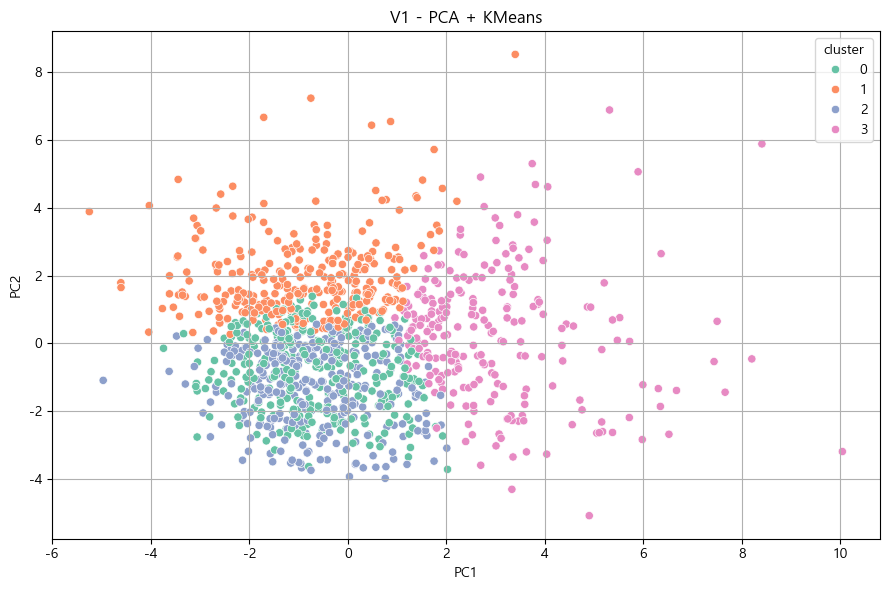

▶ V1
Silhouette Score        : 0.2640
Calinski-Harabasz Score : 441.63
Davies-Bouldin Score    : 1.1108



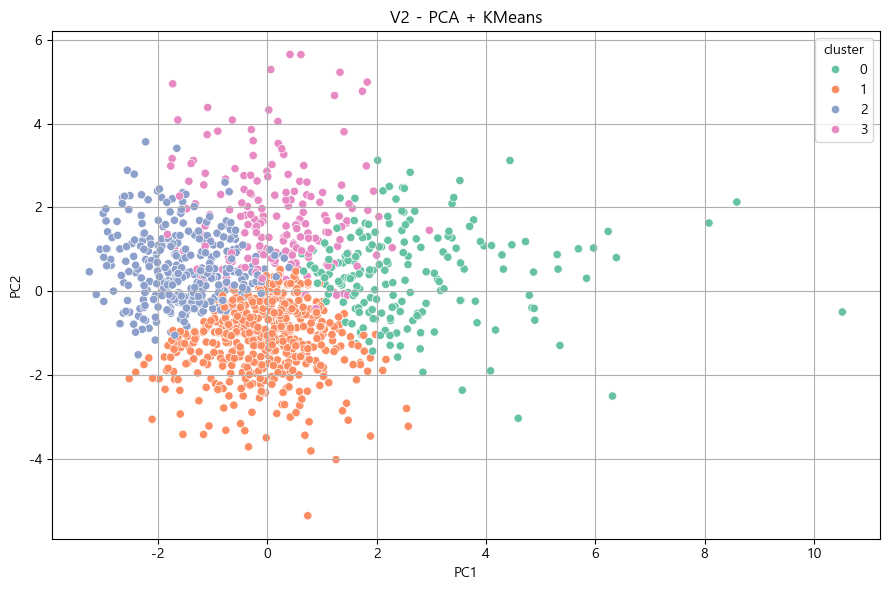

▶ V2
Silhouette Score        : 0.2653
Calinski-Harabasz Score : 454.99
Davies-Bouldin Score    : 1.1911



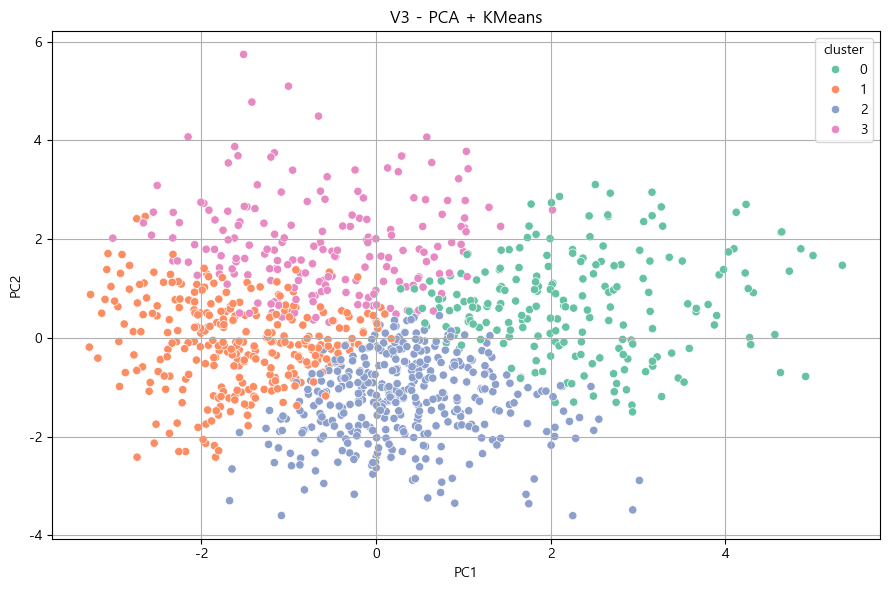

▶ V3
Silhouette Score        : 0.2514
Calinski-Harabasz Score : 435.71
Davies-Bouldin Score    : 1.2020



In [68]:
# 데이터 로딩
df_raw = pd.read_csv("clustering_filtered.csv")
columns_v2 = [
    'current_age', 'Male', 'per_capita_income', 'total_debt', 'credit_score',
    'num_credit_cards', 'tx_amount', 'tx_term', 'online_tx_ratio',
    'credit_risk', 'region_avg'
]

print("PCA + KMeans 결과")
for version in ['V1', 'V2', 'V3']:
    df = df_raw.copy()

    if version == 'V1':
        df_cluster = df.drop(columns=['id', 'state_code']).copy()
    else:
        df_cluster = df[columns_v2].copy()

    df_cluster['total_debt'] = df_cluster['total_debt'].fillna(df_cluster['total_debt'].mean())

    if version == 'V3':
        z_scores = np.abs(zscore(df_cluster))
        mask = (z_scores < 3).all(axis=1)
        df_cluster = df_cluster[mask].reset_index(drop=True)
        df = df[mask].reset_index(drop=True)

    # 표준화
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(df_cluster)

    # PCA
    pca = PCA(n_components=3)
    X_pca = pca.fit_transform(X_scaled)

    # KMeans
    kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_pca)
    df['cluster'] = labels

    # 시각화
    df_pca = pd.DataFrame(X_pca, columns=['PC1', 'PC2', 'PC3'])
    df_pca['cluster'] = labels
    plt.figure(figsize=(9, 6))
    sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='cluster', palette='Set2')
    plt.title(f"{version} - PCA + KMeans")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # 지표 출력
    print(f"▶ {version}")
    print(f"Silhouette Score        : {silhouette_score(X_pca, labels):.4f}")
    print(f"Calinski-Harabasz Score : {calinski_harabasz_score(X_pca, labels):.2f}")
    print(f"Davies-Bouldin Score    : {davies_bouldin_score(X_pca, labels):.4f}\n")


# PCA 3차원 축소 GMM

📊 PCA + GMM 결과


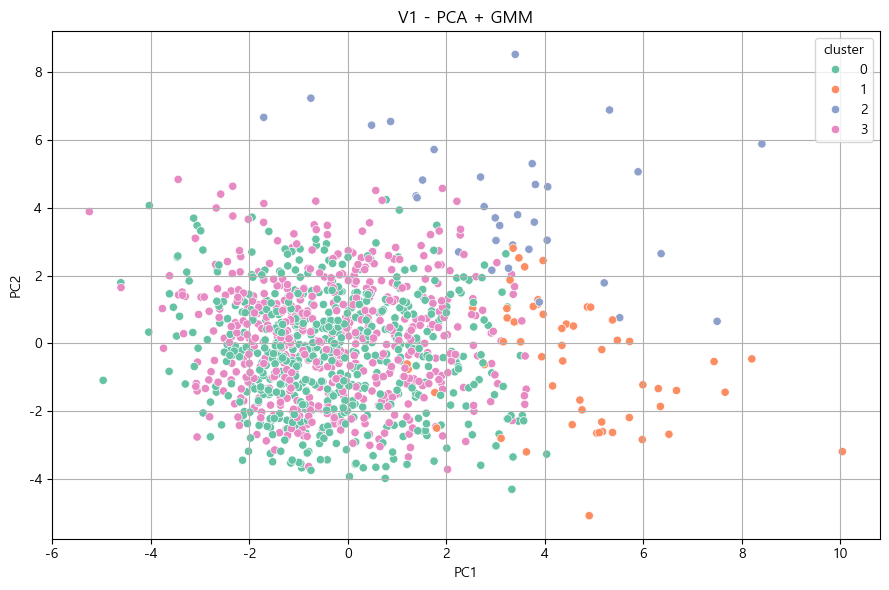

▶ V1
Silhouette Score        : 0.2542
Calinski-Harabasz Score : 249.47
Davies-Bouldin Score    : 1.3226



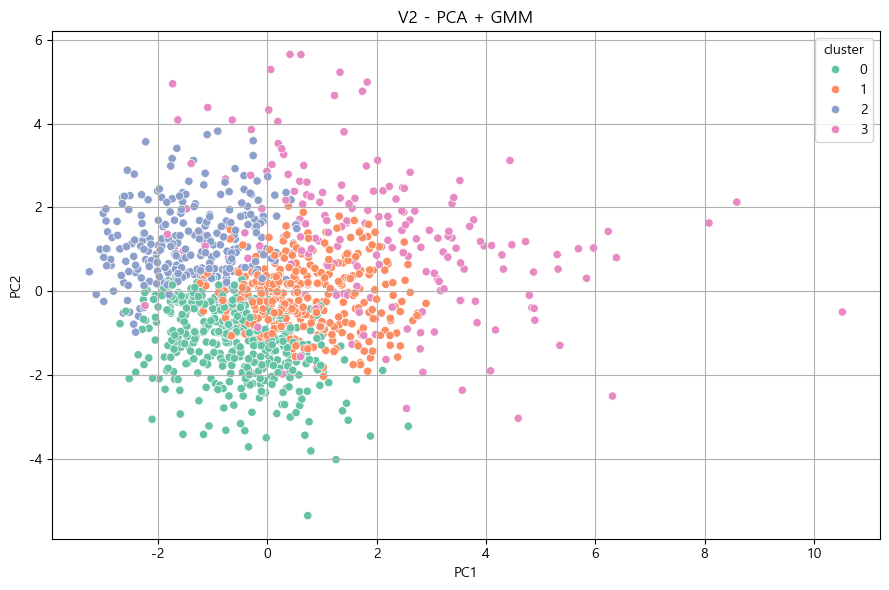

▶ V2
Silhouette Score        : 0.1992
Calinski-Harabasz Score : 328.57
Davies-Bouldin Score    : 1.4771



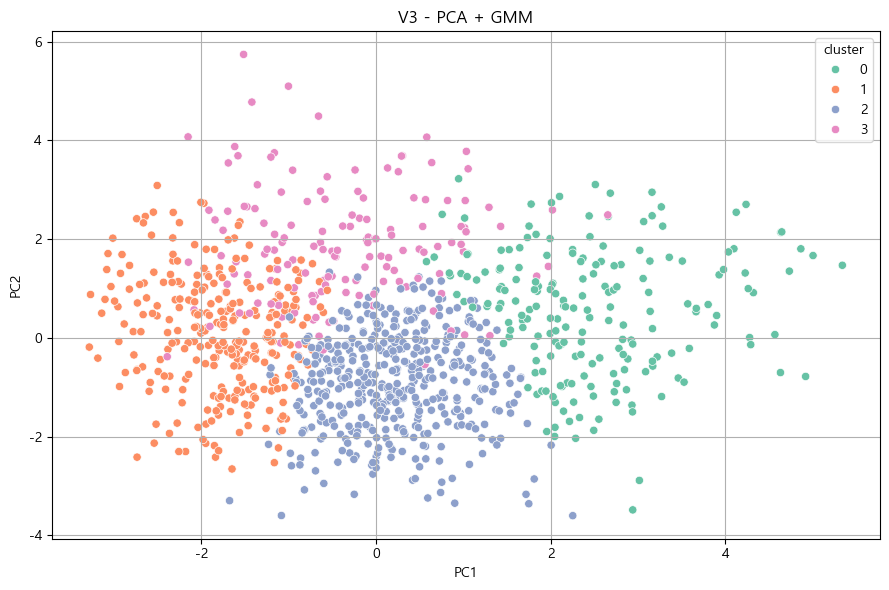

▶ V3
Silhouette Score        : 0.2474
Calinski-Harabasz Score : 395.80
Davies-Bouldin Score    : 1.2244



In [69]:
print("PCA + GMM 결과")
for version in ['V1', 'V2', 'V3']:
    df = df_raw.copy()

    if version == 'V1':
        df_cluster = df.drop(columns=['id', 'state_code']).copy()
    else:
        df_cluster = df[columns_v2].copy()

    df_cluster['total_debt'] = df_cluster['total_debt'].fillna(df_cluster['total_debt'].mean())

    if version == 'V3':
        z_scores = np.abs(zscore(df_cluster))
        mask = (z_scores < 3).all(axis=1)
        df_cluster = df_cluster[mask].reset_index(drop=True)
        df = df[mask].reset_index(drop=True)

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(df_cluster)

    pca = PCA(n_components=3)
    X_pca = pca.fit_transform(X_scaled)

    gmm = GaussianMixture(n_components=4, random_state=42)
    labels = gmm.fit_predict(X_pca)
    df['cluster'] = labels

    df_pca = pd.DataFrame(X_pca, columns=['PC1', 'PC2', 'PC3'])
    df_pca['cluster'] = labels
    plt.figure(figsize=(9, 6))
    sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='cluster', palette='Set2')
    plt.title(f"{version} - PCA + GMM")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    print(f"▶ {version}")
    print(f"Silhouette Score        : {silhouette_score(X_pca, labels):.4f}")
    print(f"Calinski-Harabasz Score : {calinski_harabasz_score(X_pca, labels):.2f}")
    print(f"Davies-Bouldin Score    : {davies_bouldin_score(X_pca, labels):.4f}\n")

# PCA 3차원 축소 DBSCAN

📊 PCA + DBSCAN 결과


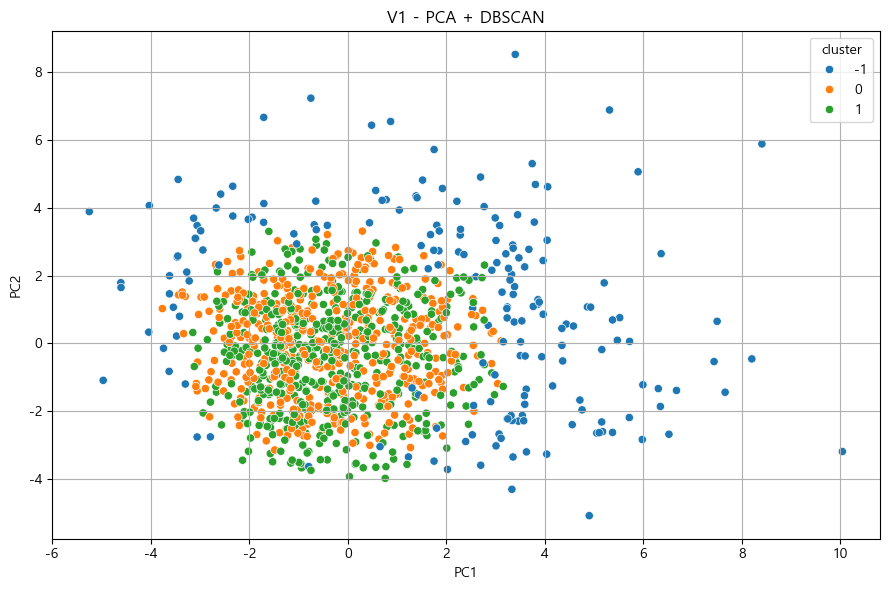

▶ V1 | 클러스터 수 (outlier 제외): 2
Silhouette Score        : 0.2449
Calinski-Harabasz Score : 222.43
Davies-Bouldin Score    : 1.9991



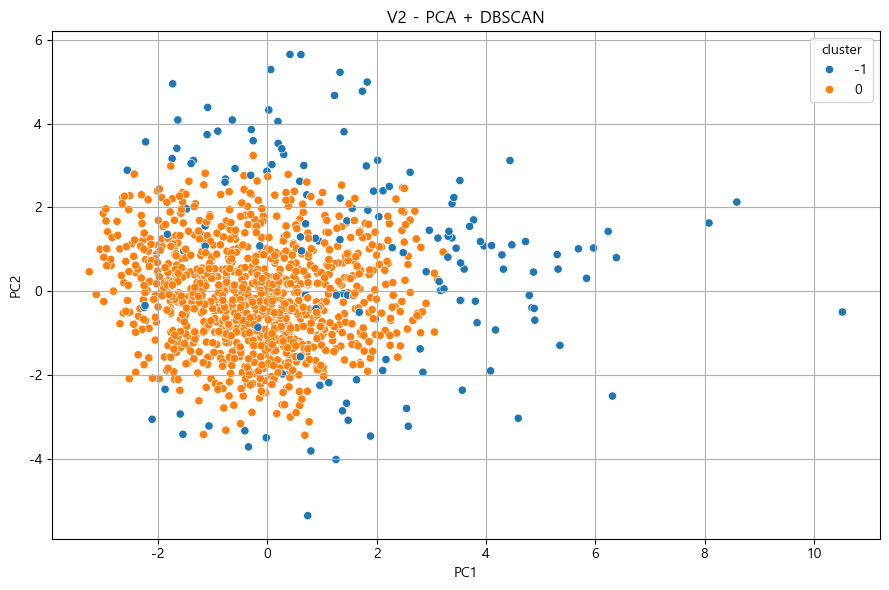

▶ V2 | 클러스터 수 (outlier 제외): 1
⚠️  클러스터가 1개 이하입니다. DBSCAN 파라미터 조정 필요



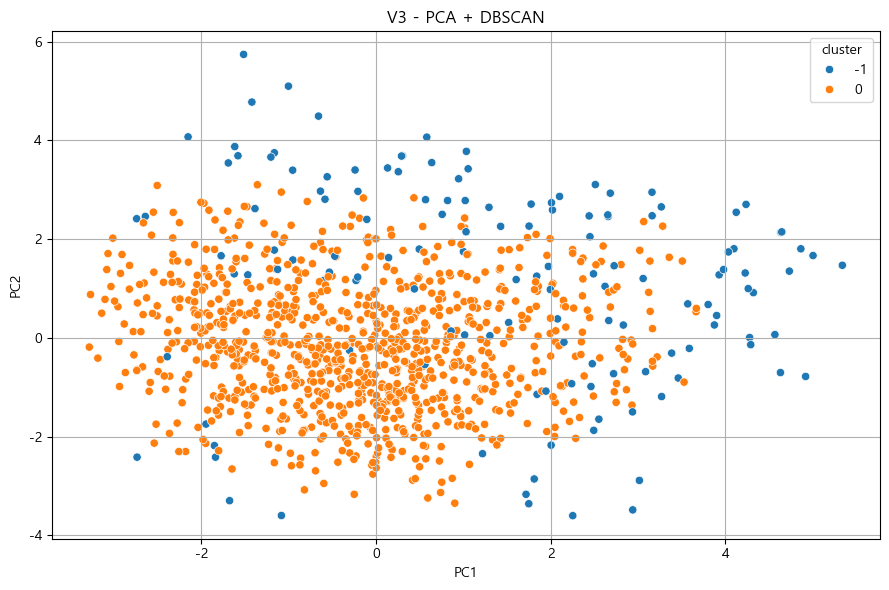

▶ V3 | 클러스터 수 (outlier 제외): 1
⚠️  클러스터가 1개 이하입니다. DBSCAN 파라미터 조정 필요



In [71]:
print("PCA + DBSCAN 결과")
for version in ['V1', 'V2', 'V3']:
    df = df_raw.copy()

    if version == 'V1':
        df_cluster = df.drop(columns=['id', 'state_code']).copy()
    else:
        df_cluster = df[columns_v2].copy()

    df_cluster['total_debt'] = df_cluster['total_debt'].fillna(df_cluster['total_debt'].mean())

    if version == 'V3':
        z_scores = np.abs(zscore(df_cluster))
        mask = (z_scores < 3).all(axis=1)
        df_cluster = df_cluster[mask].reset_index(drop=True)
        df = df[mask].reset_index(drop=True)

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(df_cluster)

    pca = PCA(n_components=3)
    X_pca = pca.fit_transform(X_scaled)

    dbscan = DBSCAN(eps=0.8, min_samples=10)  # 이 값은 변경 가능
    labels = dbscan.fit_predict(X_pca)
    df['cluster'] = labels

    df_pca = pd.DataFrame(X_pca, columns=['PC1', 'PC2', 'PC3'])
    df_pca['cluster'] = labels
    plt.figure(figsize=(9, 6))
    sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='cluster', palette='tab10')
    plt.title(f"{version} - PCA + DBSCAN")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    print(f"▶ {version} | 클러스터 수 (outlier 제외): {n_clusters}")
    if n_clusters > 1:
        print(f"Silhouette Score        : {silhouette_score(X_pca, labels):.4f}")
        print(f"Calinski-Harabasz Score : {calinski_harabasz_score(X_pca, labels):.2f}")
        print(f"Davies-Bouldin Score    : {davies_bouldin_score(X_pca, labels):.4f}\n")
    else:
        print("클러스터가 1개 이하입니다. DBSCAN 파라미터 조정 필요\n")


# 파생변수 추가  
| 변수명                      | 계산식                              | 의미                      |
| ------------------------ | -------------------------------- | ----------------------- |
| `income_to_debt_ratio`   | `per_capita_income / total_debt` | 소득 대비 부채 여유             |
| `credit_to_tx_ratio`     | `credit_score / tx_amount`       | 총 거래액 대비 신용 점수 비율          |
| `avg_tx_per_card`        | `tx_count / num_credit_cards`    | 카드 1장당 평균 거래 수          |
| `gender_gap`             | `Male - Female`                  | 성별 중심성 (남성: +1, 여성: -1) |
| `tx_amount_per_lifetime` | `tx_amount / lifetime`           | 평균 거래액                  |
| `debt_to_credit_ratio`   | `total_debt / credit_score`      | 신용 대비 부채 비율            |  
- PCA Kmeans V2 로 진행


C:\Users\user\AppData\Local\Temp\ipykernel_15152\633523297.py:51: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Malgun Gothic.
  plt.tight_layout()
C:\Users\user\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Malgun Gothic.
  fig.canvas.print_figure(bytes_io, **kw)


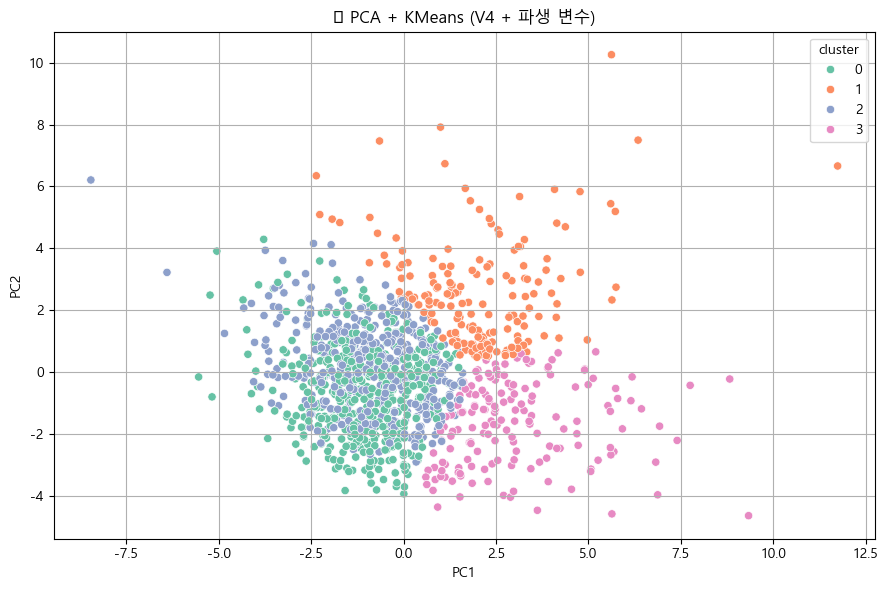

✅ 클러스터링 성능 평가 (V4 + 파생변수)
Silhouette Score        : 0.3487
Calinski-Harabasz Score : 480.34
Davies-Bouldin Score    : 1.1127


In [72]:
# 원본 로드
df = pd.read_csv("clustering_filtered.csv")

# V2 원본 변수
columns_v2 = [
    'current_age', 'Male', 'per_capita_income', 'total_debt', 'credit_score',
    'num_credit_cards', 'tx_count', 'tx_amount', 'tx_term',
    'online_tx_ratio', 'credit_risk', 'region_avg', 'lifetime', 'Female'
]
df_v4 = df[columns_v2].copy()

# 결측치 처리
df_v4['total_debt'] = df_v4['total_debt'].fillna(df_v4['total_debt'].mean())

# 파생 변수 생성
df_v4['income_to_debt_ratio'] = df_v4['per_capita_income'] / (df_v4['total_debt'] + 1)
df_v4['credit_to_tx_ratio'] = df_v4['credit_score'] / (df_v4['tx_amount'] + 1)
df_v4['avg_tx_per_card'] = df_v4['tx_count'] / (df_v4['num_credit_cards'] + 1)
df_v4['gender_gap'] = df_v4['Male'] - df_v4['Female']
df_v4['tx_amount_per_lifetime'] = df_v4['tx_amount'] / (df_v4['lifetime'] + 1)
df_v4['debt_to_credit_ratio'] = df_v4['total_debt'] / (df_v4['credit_score'] + 1)

# 정규화
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_v4)

# PCA 축소
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)

# KMeans 클러스터링
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
labels = kmeans.fit_predict(X_pca)

# 시각화
df_pca = pd.DataFrame(X_pca, columns=['PC1', 'PC2', 'PC3'])
df_pca['cluster'] = labels
plt.figure(figsize=(9, 6))
sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='cluster', palette='Set2')
plt.title("PCA + KMeans (V4 + 파생 변수)")
plt.grid(True)
plt.tight_layout()
plt.show()

# 성능 평가
print("클러스터링 성능 평가 (V4 + 파생변수)")
print(f"Silhouette Score        : {silhouette_score(X_pca, labels):.4f}")
print(f"Calinski-Harabasz Score : {calinski_harabasz_score(X_pca, labels):.2f}")
print(f"Davies-Bouldin Score    : {davies_bouldin_score(X_pca, labels):.4f}")

# KMeans + UMAP(2차원)  
- 변수 최적화 + 파생변수

C:\Users\user\anaconda3\envs\clustering_env\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


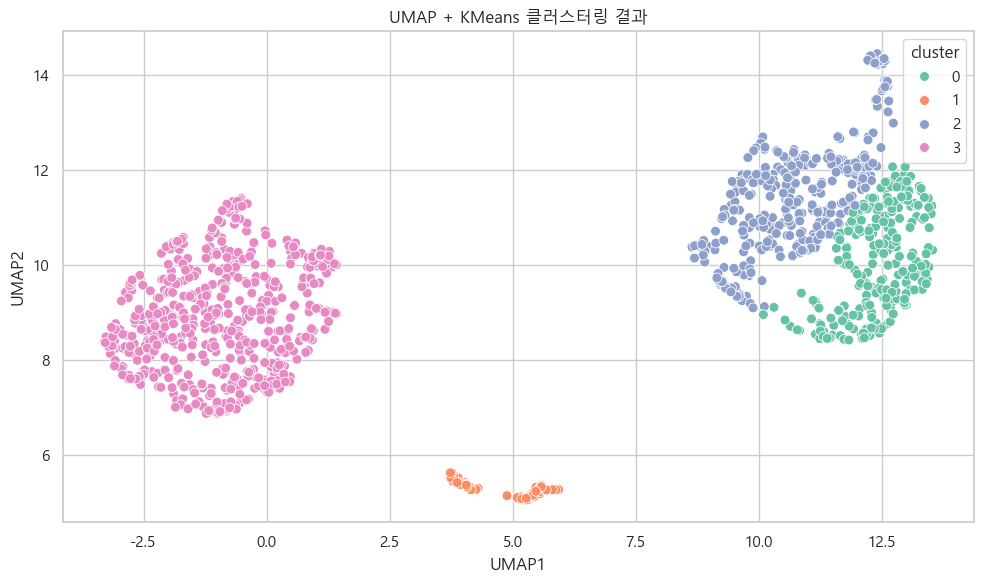

📊 클러스터링 성능 지표 요약:


n_clusters       init  n_init  max_iter  random_state      tol  \
0           4  k-means++      10       300            42  default   

   Silhouette Score  Davies-Bouldin Index  Calinski-Harabasz Score  \
0            0.5277                0.7528                  6734.66   

                      Note  
0  UMAP + KMeans + V4 파생변수


📊 클러스터별 요약 통계표:


C:\Users\user\AppData\Local\Temp\ipykernel_27680\1007981335.py:73: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  formatted_summary = cluster_summary.applymap(lambda x: f"{x:,.2f}")


current_age  Male per_capita_income total_debt credit_score  \
cluster                                                               
0             62.04  0.00         19,943.13  25,344.05       720.69   
1             54.28  0.41         23,809.78       0.00       741.81   
2             46.39  0.06         24,531.57  84,494.05       707.11   
3             52.74  1.00         22,993.50  62,042.49       710.71   

        num_credit_cards   tx_count   tx_amount tx_term online_tx_ratio  \
cluster                                                                   
0                   4.21   9,090.52  358,971.68    7.52            0.09   
1                   4.14  11,141.10  474,269.55    5.95            0.08   
2                   3.25  11,889.25  528,402.67    6.12            0.12   
3                   3.71  11,179.77  484,305.18    6.48            0.11   

        credit_risk  region_avg  lifetime Female income_to_debt_ratio  \
cluster                                                                 
0             34.47  458,998.05  3,563.80   1.00                63.28   
1              0.00  466,672.38  3,532.17   0.59            23,809.78   
2            119.28  470,822.30  3,338.39   0.94                56.16   
3             89.03  464,866.27  3,547.65   0.00                28.13   

        credit_to_tx_ratio avg_tx_per_card gender_gap tx_amount_per_lifetime  \
cluster                                                                        
0                     0.00        1,826.72      -1.00                 100.55   
1                     0.00        2,284.96      -0.17                 135.17   
2                     0.00        3,040.01      -0.89                 154.83   
3                     0.00        2,612.73       1.00                 136.66   

        debt_to_credit_ratio  
cluster                       
0                      34.91  
1                       0.00  
2                     119.61  
3                      89.47

In [17]:
# 1. 데이터 로딩 & V4 구성
df = pd.read_csv("clustering_filtered.csv")

columns_v2 = [
    'current_age', 'Male', 'per_capita_income', 'total_debt', 'credit_score',
    'num_credit_cards', 'tx_count', 'tx_amount', 'tx_term',
    'online_tx_ratio', 'credit_risk', 'region_avg', 'lifetime', 'Female'
]
df_v4 = df[columns_v2].copy()
df_v4['total_debt'] = df_v4['total_debt'].fillna(df_v4['total_debt'].mean())

# 2. 파생 변수 추가 (6개)
df_v4['income_to_debt_ratio'] = df_v4['per_capita_income'] / (df_v4['total_debt'] + 1)
df_v4['credit_to_tx_ratio'] = df_v4['credit_score'] / (df_v4['tx_amount'] + 1)
df_v4['avg_tx_per_card'] = df_v4['tx_count'] / (df_v4['num_credit_cards'] + 1)
df_v4['gender_gap'] = df_v4['Male'] - df_v4['Female']
df_v4['tx_amount_per_lifetime'] = df_v4['tx_amount'] / (df_v4['lifetime'] + 1)
df_v4['debt_to_credit_ratio'] = df_v4['total_debt'] / (df_v4['credit_score'] + 1)

# 3. 정규화
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_v4)

# 4. UMAP 차원 축소
reducer = umap.UMAP(n_components=2, random_state=42)
X_umap = reducer.fit_transform(X_scaled)

# 5. KMeans 클러스터링
kmeans = KMeans(
    n_clusters=4,
    init='k-means++',
    random_state=42,
    n_init=10,
    max_iter=300
)
labels = kmeans.fit_predict(X_umap)
df_v4['cluster'] = labels

# 6. 시각화
df_umap = pd.DataFrame(X_umap, columns=['UMAP1', 'UMAP2'])
df_umap['cluster'] = labels
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_umap, x='UMAP1', y='UMAP2', hue='cluster', palette='Set2', s=50)
plt.title("UMAP + KMeans 클러스터링 결과")
plt.grid(True)
plt.tight_layout()
plt.show()

# 7. 클러스터링 성능 지표 계산
sil_score = silhouette_score(X_umap, labels)
ch_score = calinski_harabasz_score(X_umap, labels)
db_score = davies_bouldin_score(X_umap, labels)

# 8. 지표 표 형식 출력
results_df = pd.DataFrame([{
    "n_clusters": 4,
    "init": "k-means++",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 42,
    "tol": "default",
    "Silhouette Score": round(sil_score, 4),
    "Davies-Bouldin Index": round(db_score, 4),
    "Calinski-Harabasz Score": round(ch_score, 2),
    "Note": "UMAP + KMeans + V4 파생변수"
}])

print("클러스터링 성능 지표 요약:")
display(results_df)

# 9. 클러스터별 요약 통계표
cluster_summary = df_v4.groupby('cluster').mean(numeric_only=True)
formatted_summary = cluster_summary.applymap(lambda x: f"{x:,.2f}")

print("\n클러스터별 요약 통계표:")
display(formatted_summary)

| 클러스터          | 주요 특성 요약                                                                                      | 고객군 해석                                     |
| ------------- | --------------------------------------------------------------------------------------------- | ------------------------------------------ |
| **Cluster 0** | - 평균 연령 62세<br>- 여성 100%<br>- 카드 4.2장, 중간 소비<br>- 부채 존재 (25,344원)<br>- 신용점수 721               | **고령 여성 소비군**<br>보수적 소비 성향, 리스크 모니터링 필요    |
| **Cluster 1** | - 평균 연령 54세<br>- 남성 41%, 여성 다수<br>- 부채 없음<br>- 신용도 가장 높음 (742)<br>- 활동성도 높음                   | **우량 고객군**<br>고신용·저부채, 프리미엄 고객화 전략 적합      |
| **Cluster 2** | - 평균 연령 46세<br>- 여성 94%<br>- 소득 가장 높음<br>- 부채 큼 (84,494원)<br>- 신용도 낮음 (707)<br>- 거래량·소비 매우 활발 | **고위험 고소득 소비군**<br>적극 소비층, 부채·신용 리스크 관리 필요 |
| **Cluster 3** | - 평균 연령 52.7세<br>- 남성 100%<br>- 모든 지표 평균 수준<br>- 부채 있음 (62,042원)<br>- 중간 정도 소비·거래             | **일반적 남성 활동군**<br>안정적 소비층, 기본 유지 전략 적합     |


### 각 변수 시각화

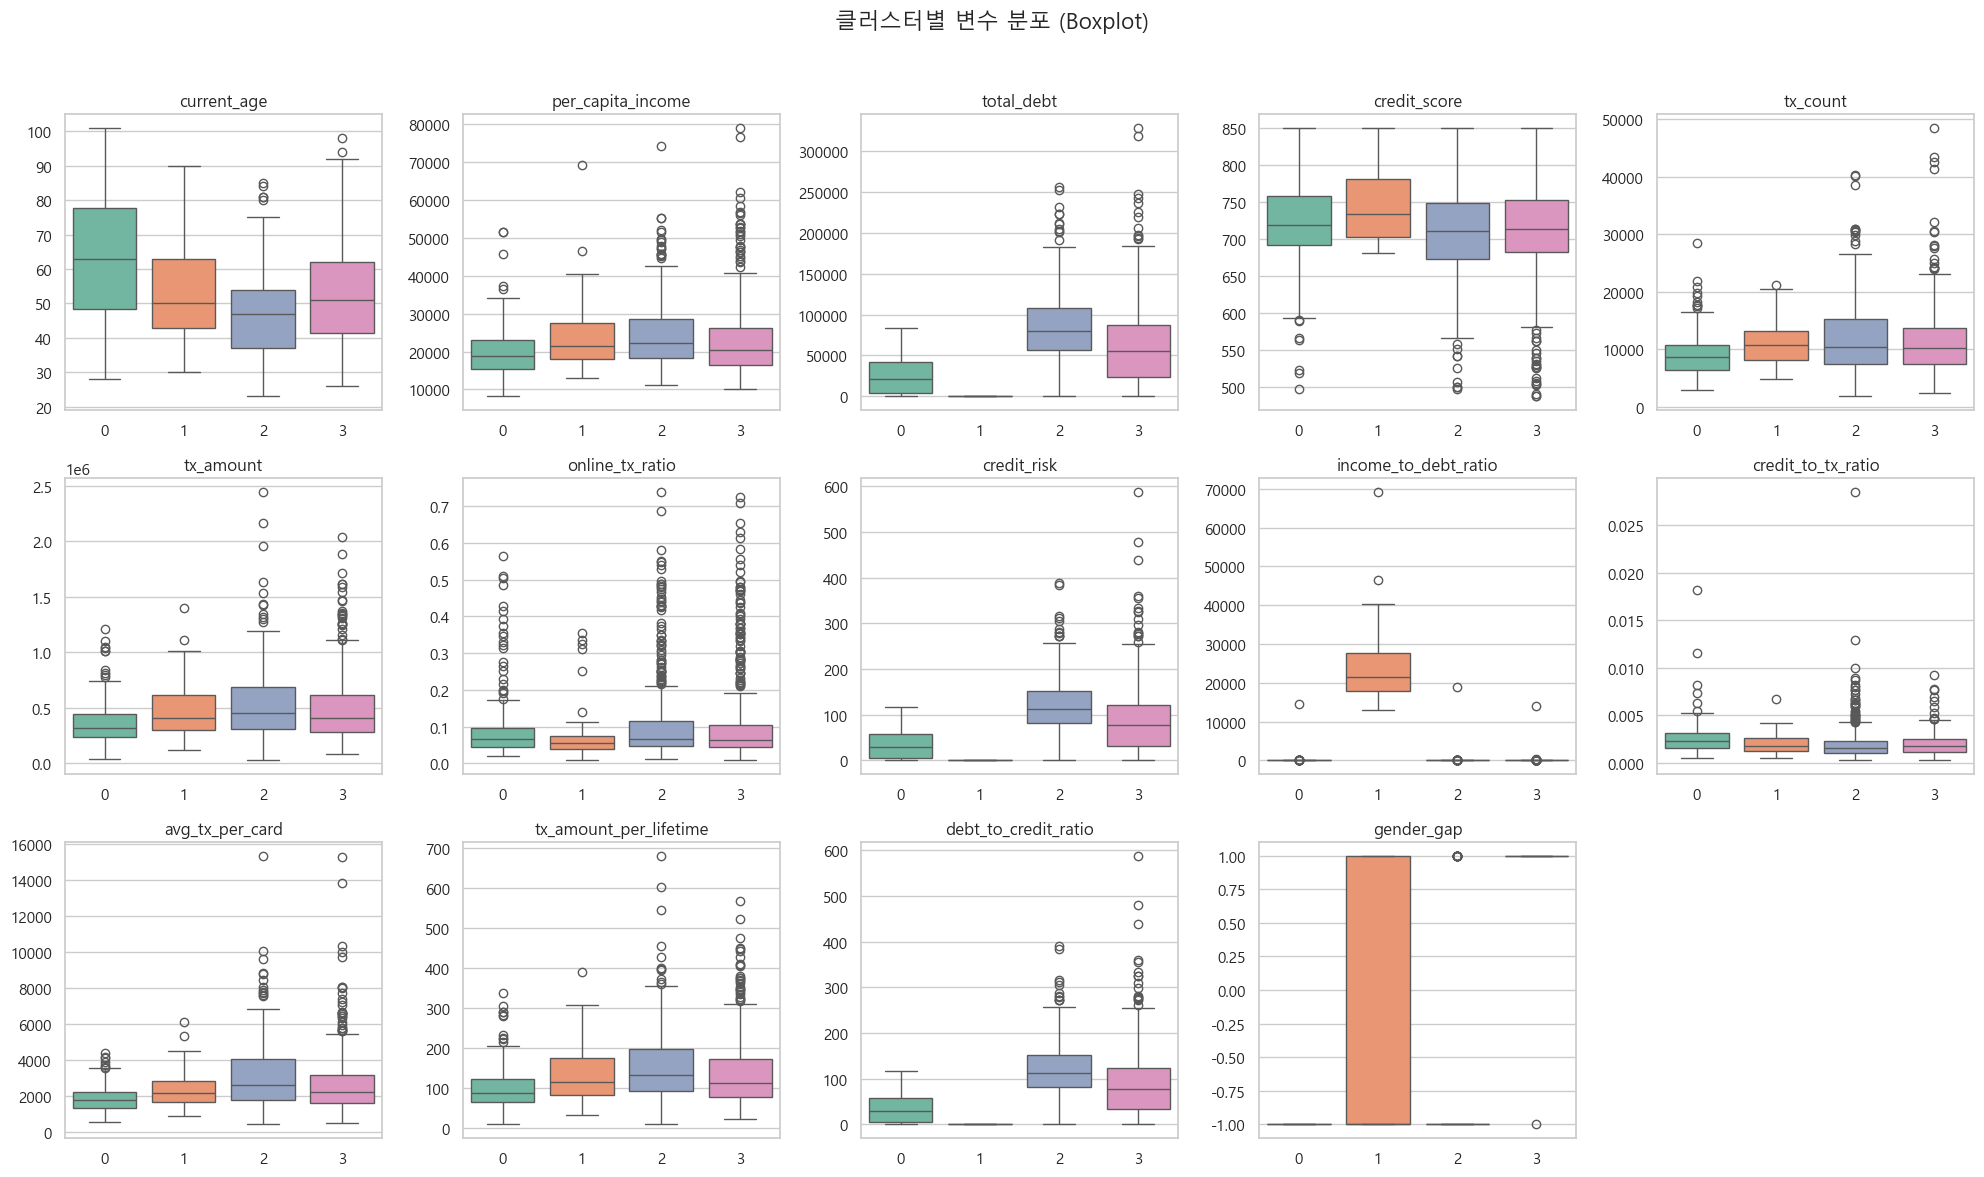

In [14]:
# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# 시각화할 변수 목록
vars_to_plot = [
    'current_age', 'per_capita_income', 'total_debt', 'credit_score',
    'tx_count', 'tx_amount', 'online_tx_ratio', 'credit_risk',
    'income_to_debt_ratio', 'credit_to_tx_ratio', 'avg_tx_per_card',
    'tx_amount_per_lifetime', 'debt_to_credit_ratio', 'gender_gap'
]

# 서브플롯 설정
num_vars = len(vars_to_plot)
cols = 5
rows = (num_vars + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(20, 12))
axes = axes.flatten()

for i, var in enumerate(vars_to_plot):
    sns.boxplot(data=df_v4, x='cluster', y=var, hue='cluster', palette='Set2', legend=False, ax=axes[i])
    axes[i].set_title(f'{var}')
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")

# 나머지 빈칸 제거
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

fig.suptitle("클러스터별 변수 분포 (Boxplot)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

성별을 포함해 클러스터링을 진행했더니 군집이 성별 기준으로 지나치게 극단적으로 나뉘어 분석에 활용하기 어려움.

### 성별 제외 클러스터링

C:\Users\user\anaconda3\envs\clustering_env\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


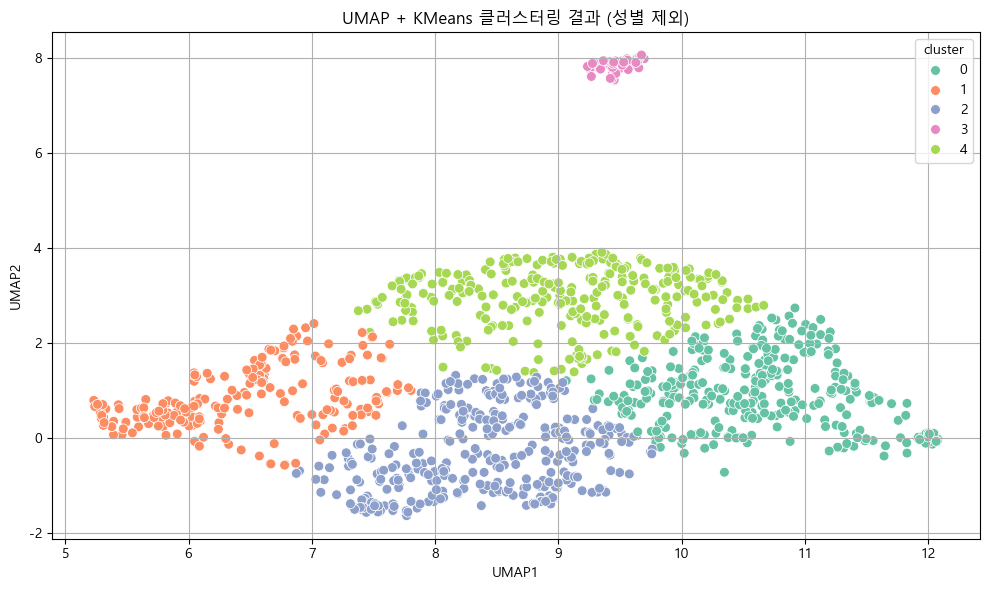

📊 클러스터링 성능 지표 요약:


n_clusters    init  n_init  max_iter  random_state      tol  \
0           4  random      10       300            42  default   

   Silhouette Score  Davies-Bouldin Index  Calinski-Harabasz Score  \
0              0.47                0.6629                  1685.74   

                              Note  
0  UMAP + KMeans + V4 파생변수 (성별 제외)


📊 클러스터별 요약 통계표:


C:\Users\user\AppData\Local\Temp\ipykernel_27800\3973970592.py:72: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  formatted_summary = cluster_summary.applymap(lambda x: f"{x:,.2f}")


current_age per_capita_income  total_debt credit_score  \
cluster                                                          
0             45.12         18,610.72   58,564.31       717.13   
1             53.72         25,516.43   53,800.79       706.65   
2             46.56         26,169.91  103,706.52       701.01   
3             54.28         23,809.78        0.00       741.81   
4             68.23         21,466.20   18,305.23       722.30   

        num_credit_cards   tx_count   tx_amount tx_term online_tx_ratio  \
cluster                                                                   
0                   3.04   6,401.51  240,024.77    9.80            0.09   
1                   3.60  17,916.78  806,490.22    3.62            0.25   
2                   3.43  11,149.33  512,680.09    5.77            0.07   
3                   4.14  11,141.10  474,269.55    5.95            0.08   
4                   4.74  10,533.58  426,148.31    6.21            0.06   

        credit_risk  region_avg  lifetime income_to_debt_ratio  \
cluster                                                          
0             81.80  433,287.12  3,294.25                90.44   
1             76.33  489,822.29  3,569.32                92.71   
2            149.26  471,314.54  3,541.29                 0.28   
3              0.00  466,672.38  3,532.17            23,809.78   
4             24.85  475,949.57  3,583.96                 8.20   

        credit_to_tx_ratio avg_tx_per_card tx_amount_per_lifetime  \
cluster                                                             
0                     0.00        1,718.36                  74.95   
1                     0.00        4,285.22                 225.87   
2                     0.00        2,838.64                 145.40   
3                     0.00        2,284.96                 135.17   
4                     0.00        1,923.16                 118.85   

        debt_to_credit_ratio  
cluster                       
0                      82.15  
1                      76.96  
2                     149.54  
3                       0.00  
4                      25.29

In [4]:
# 1. 데이터 로딩 & V4 구성 (성별 제외)
df = pd.read_csv("clustering_filtered.csv")

columns_v4 = [
    'current_age', 'per_capita_income', 'total_debt', 'credit_score',
    'num_credit_cards', 'tx_count', 'tx_amount', 'tx_term',
    'online_tx_ratio', 'credit_risk', 'region_avg', 'lifetime'
]
df_v4 = df[columns_v4].copy()
df_v4['total_debt'] = df_v4['total_debt'].fillna(df_v4['total_debt'].mean())

# 2. 파생 변수 추가 (5개만 사용, gender_gap 제외)
df_v4['income_to_debt_ratio'] = df_v4['per_capita_income'] / (df_v4['total_debt'] + 1)
df_v4['credit_to_tx_ratio'] = df_v4['credit_score'] / (df_v4['tx_amount'] + 1)
df_v4['avg_tx_per_card'] = df_v4['tx_count'] / (df_v4['num_credit_cards'] + 1
df_v4['tx_amount_per_lifetime'] = df_v4['tx_amount'] / (df_v4['lifetime'] + 1)
df_v4['debt_to_credit_ratio'] = df_v4['total_debt'] / (df_v4['credit_score'] + 1)

# 3. 정규화
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_v4)

# 4. UMAP 차원 축소 (튜닝된 파라미터 적용)
reducer = umap.UMAP(n_components=2, n_neighbors=47, min_dist=0.0, random_state=42)
X_umap = reducer.fit_transform(X_scaled)

# 5. KMeans 클러스터링
kmeans = KMeans(
    n_clusters=5,
    init='random',
    random_state=42,
    n_init=10,
    max_iter=700
)
labels = kmeans.fit_predict(X_umap)
df_v4['cluster'] = labels

# 6. 시각화
df_umap = pd.DataFrame(X_umap, columns=['UMAP1', 'UMAP2'])
df_umap['cluster'] = labels
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_umap, x='UMAP1', y='UMAP2', hue='cluster', palette='Set2', s=50)
plt.title("UMAP + KMeans 클러스터링 결과 (성별 제외)")
plt.grid(True)
plt.tight_layout()
plt.show()

# 7. 클러스터링 성능 지표 계산
sil_score = silhouette_score(X_umap, labels)
ch_score = calinski_harabasz_score(X_umap, labels)
db_score = davies_bouldin_score(X_umap, labels)

# 8. 지표 표 형식 출력
results_df = pd.DataFrame([{
    "n_clusters": 4,
    "init": "random",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 42,
    "tol": "default",
    "Silhouette Score": round(sil_score, 4),
    "Davies-Bouldin Index": round(db_score, 4),
    "Calinski-Harabasz Score": round(ch_score, 2),
    "Note": "UMAP + KMeans + V4 파생변수 (성별 제외)"
}])

print("클러스터링 성능 지표 요약:")
display(results_df)

# 9. 클러스터별 요약 통계표
cluster_summary = df_v4.groupby('cluster').mean(numeric_only=True)
formatted_summary = cluster_summary.applymap(lambda x: f"{x:,.2f}")

print("\n클러스터별 요약 통계표:")
display(formatted_summary)

| 클러스터          | 주요 특성 요약                                       | 고객군 해석                                               |
| ------------- | ---------------------------------------------- | ---------------------------------------------------- |
| **Cluster 0** | 평균 연령 68세, 카드 4.7장, 부채 보유, 신용도 723, 소비 보통 수준   | **고령 안정 소비자**<br>연령대 높고 부채·소득·소비 모두 평균 수준, 신중한 소비 패턴 |
| **Cluster 1** | 평균 연령 49세, 소득·부채·소비 모두 최고 수준, 신용도 699(낮음)      | **중년 고위험 소비자**<br>높은 소비·부채 대비 신용이 낮음, 리스크 모니터링 필요    |
| **Cluster 2** | 평균 연령 54세, 부채 없음, 신용도 가장 높음(741), 소비 적정        | **고신용 무부채 소비자**<br>건전한 금융 상태, 프리미엄 전략 대상             |
| **Cluster 3** | 평균 연령 45세, 카드 적고 소비 낮음, 부채·소득 모두 낮음            | **저소득·저소비 일반 고객**<br>보수적인 소비 성향, 프로모션 확대 대상 가능       |
| **Cluster 4** | 평균 연령 47세, 고소득(26K), 고부채(103K), 위험도 가장 높음(149) | **고소득 고위험 고객**<br>소득은 높지만 과도한 부채와 위험도로 관리 대상 우선순위    |

# KMeans + UMAP(2차원) + 변수중요도

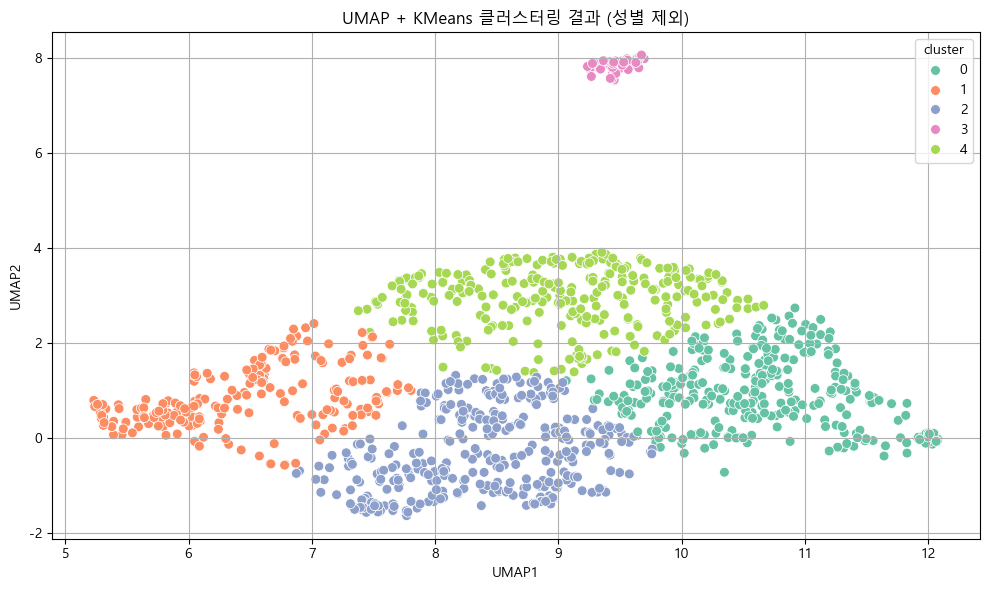

📊 클러스터링 성능 지표 요약:


n_clusters    init  n_init  max_iter  random_state  Silhouette Score  \
0           5  random      10       700            42              0.47   

   Davies-Bouldin Index  Calinski-Harabasz Score  \
0                0.6629                  1685.74   

                              Note  
0  UMAP + KMeans + V4 파생변수 (성별 제외)


📊 클러스터별 요약 통계표:


current_age per_capita_income  total_debt credit_score  \
cluster                                                          
0             45.12         18,610.72   58,564.31       717.13   
1             53.72         25,516.43   53,800.79       706.65   
2             46.56         26,169.91  103,706.52       701.01   
3             54.28         23,809.78        0.00       741.81   
4             68.23         21,466.20   18,305.23       722.30   

        num_credit_cards   tx_count   tx_amount tx_term online_tx_ratio  \
cluster                                                                   
0                   3.04   6,401.51  240,024.77    9.80            0.09   
1                   3.60  17,916.78  806,490.22    3.62            0.25   
2                   3.43  11,149.33  512,680.09    5.77            0.07   
3                   4.14  11,141.10  474,269.55    5.95            0.08   
4                   4.74  10,533.58  426,148.31    6.21            0.06   

        credit_risk  region_avg  lifetime income_to_debt_ratio  \
cluster                                                          
0             81.80  433,287.12  3,294.25                90.44   
1             76.33  489,822.29  3,569.32                92.71   
2            149.26  471,314.54  3,541.29                 0.28   
3              0.00  466,672.38  3,532.17            23,809.78   
4             24.85  475,949.57  3,583.96                 8.20   

        credit_to_tx_ratio avg_tx_per_card tx_amount_per_lifetime  \
cluster                                                             
0                     0.00        1,718.36                  74.95   
1                     0.00        4,285.22                 225.87   
2                     0.00        2,838.64                 145.40   
3                     0.00        2,284.96                 135.17   
4                     0.00        1,923.16                 118.85   

        debt_to_credit_ratio  
cluster                       
0                      82.15  
1                      76.96  
2                     149.54  
3                       0.00  
4                      25.29

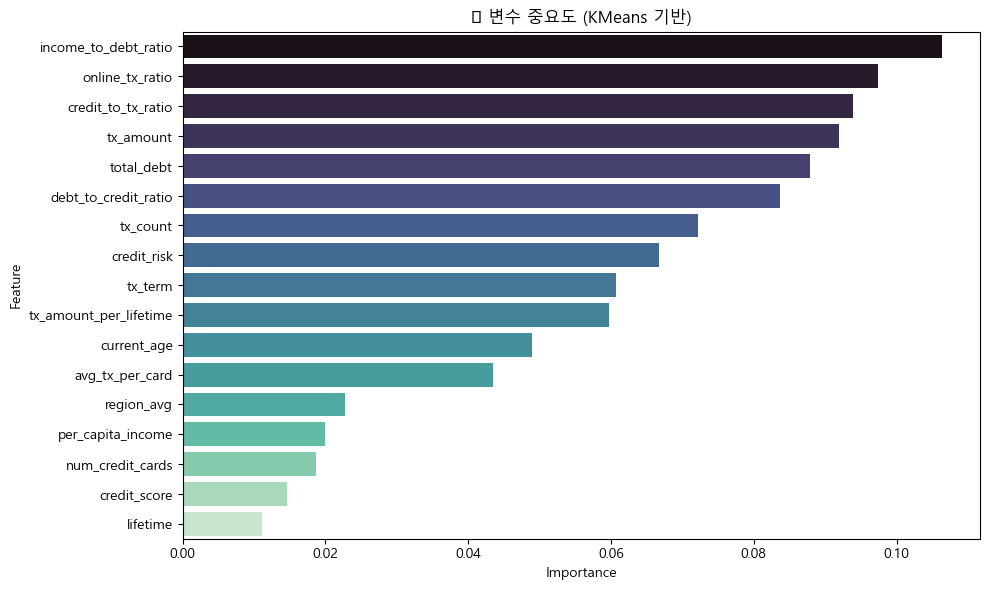


📌 변수 중요도 순위표:


Feature  Importance
12    income_to_debt_ratio    0.106377
8          online_tx_ratio    0.097450
13      credit_to_tx_ratio    0.093862
6                tx_amount    0.091916
2               total_debt    0.087948
16    debt_to_credit_ratio    0.083728
5                 tx_count    0.072179
9              credit_risk    0.066768
7                  tx_term    0.060730
15  tx_amount_per_lifetime    0.059672
0              current_age    0.048877
14         avg_tx_per_card    0.043508
10              region_avg    0.022696
1        per_capita_income    0.019877
4         num_credit_cards    0.018637
3             credit_score    0.014622
11                lifetime    0.011151

In [12]:
# 1. 데이터 로딩 & V4 구성 (성별 제외)
df = pd.read_csv("clustering_filtered.csv")

columns_v4 = [
    'current_age', 'per_capita_income', 'total_debt', 'credit_score',
    'num_credit_cards', 'tx_count', 'tx_amount', 'tx_term',
    'online_tx_ratio', 'credit_risk', 'region_avg', 'lifetime'
]
df_v4 = df[columns_v4].copy()
df_v4['total_debt'] = df_v4['total_debt'].fillna(df_v4['total_debt'].mean())

# 2. 파생 변수 추가 (5개만 사용, gender_gap 제외)
df_v4['income_to_debt_ratio'] = df_v4['per_capita_income'] / (df_v4['total_debt'] + 1)
df_v4['credit_to_tx_ratio'] = df_v4['credit_score'] / (df_v4['tx_amount'] + 1)
df_v4['avg_tx_per_card'] = df_v4['tx_count'] / (df_v4['num_credit_cards'] + 1)
df_v4['tx_amount_per_lifetime'] = df_v4['tx_amount'] / (df_v4['lifetime'] + 1)
df_v4['debt_to_credit_ratio'] = df_v4['total_debt'] / (df_v4['credit_score'] + 1)

# 3. 정규화
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_v4)

# 4. UMAP 차원 축소 (튜닝된 파라미터 적용)
reducer = umap.UMAP(n_components=2, n_neighbors=47, min_dist=0.0, random_state=42)
X_umap = reducer.fit_transform(X_scaled)

# 5. KMeans 클러스터링
kmeans = KMeans(
    n_clusters=5,
    init='random',
    random_state=42,
    n_init=10,
    max_iter=700
)
labels = kmeans.fit_predict(X_umap)
df_v4['cluster'] = labels

# 6. 시각화
df_umap = pd.DataFrame(X_umap, columns=['UMAP1', 'UMAP2'])
df_umap['cluster'] = labels
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_umap, x='UMAP1', y='UMAP2', hue='cluster', palette='Set2', s=50)
plt.title("UMAP + KMeans 클러스터링 결과 (성별 제외)")
plt.grid(True)
plt.tight_layout()
plt.show()

# 7. 클러스터링 성능 지표 계산
sil_score = silhouette_score(X_umap, labels)
ch_score = calinski_harabasz_score(X_umap, labels)
db_score = davies_bouldin_score(X_umap, labels)

# 8. 지표 표 형식 출력
results_df = pd.DataFrame([{
    "n_clusters": 5,
    "init": "random",
    "n_init": 10,
    "max_iter": 700,
    "random_state": 42,
    "Silhouette Score": round(sil_score, 4),
    "Davies-Bouldin Index": round(db_score, 4),
    "Calinski-Harabasz Score": round(ch_score, 2),
    "Note": "UMAP + KMeans + V4 파생변수 (성별 제외)"
}])

print("클러스터링 성능 지표 요약:")
display(results_df)

# 9. 클러스터별 요약 통계표
cluster_summary = df_v4.groupby('cluster').mean(numeric_only=True)
formatted_summary = cluster_summary.applymap(lambda x: f"{x:,.2f}")
print("\n클러스터별 요약 통계표:")
display(formatted_summary)

# 10. 변수 중요도 분석 (KMeans 클러스터 라벨 기반)
X_input = X_scaled
y_target = labels
input_columns = df_v4.drop(columns=['cluster']).columns  # 클러스터 제외

rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_input, y_target)

importances = rf.feature_importances_
importance_df = pd.DataFrame({
    'Feature': input_columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# 11. 변수 중요도 시각화
plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df, x='Importance', y='Feature', palette='mako')
plt.title("변수 중요도 (KMeans 기반)")
plt.tight_layout()
plt.show()

# 12. 변수 중요도 출력
print("\n변수 중요도 순위표:")
display(importance_df)

### 변수 중요도 상위 8개 조합 최종 클러스터링

C:\Users\user\anaconda3\envs\clustering_env\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


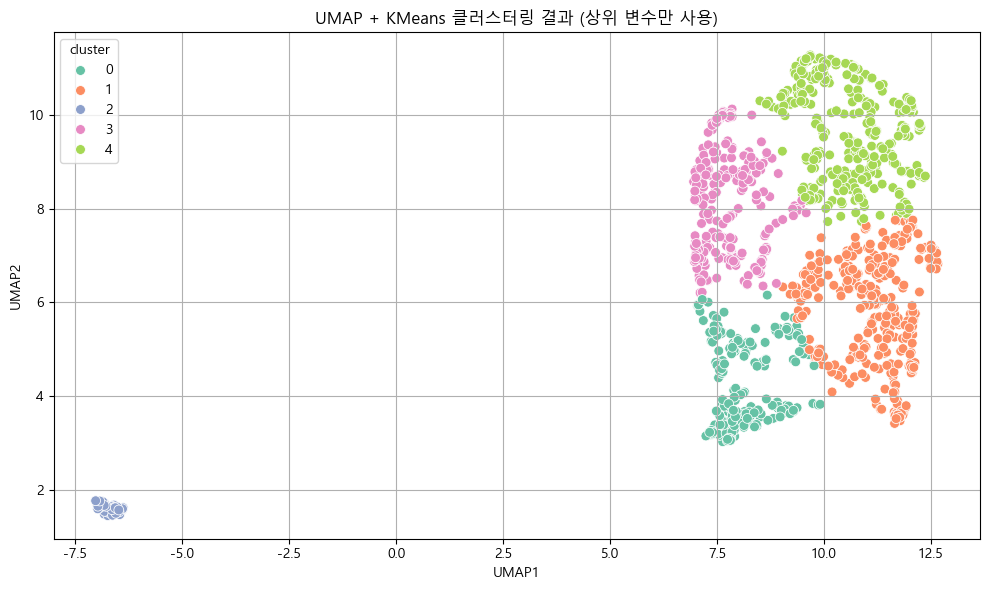

📊 클러스터링 성능 지표 요약:


n_clusters  Silhouette Score  Davies-Bouldin Index  \
0           5            0.4817                0.6138   

   Calinski-Harabasz Score                    Note  
0                  3575.66  UMAP + KMeans (상위 변수만)


📊 클러스터별 요약 통계표:


C:\Users\user\AppData\Local\Temp\ipykernel_2348\4127640618.py:86: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  formatted_summary = cluster_summary.applymap(lambda x: f"{x:,.2f}")


income_to_debt_ratio online_tx_ratio credit_to_tx_ratio   tx_amount  \
cluster                                                                       
0                      95.03            0.28               0.00  810,686.37   
1                       0.26            0.07               0.00  478,948.23   
2                  23,490.98            0.08               0.00  462,961.50   
3                       7.18            0.06               0.00  495,146.13   
4                       2.10            0.08               0.00  236,800.99   

         total_debt debt_to_credit_ratio   tx_count credit_risk  
cluster                                                          
0         58,134.65                82.94  17,753.07       82.55  
1        107,596.46               154.78  10,107.86      154.50  
2              0.00                 0.00  10,885.93        0.00  
3         20,296.98                28.37  12,237.94       27.74  
4         44,414.22                62.16   6,704.85       61.79


📌 클러스터별 샘플 수:
cluster
0    206
1    345
2     60
3    250
4    340
Name: count, dtype: int64


In [8]:
# 1. 데이터 로딩
df = pd.read_csv("clustering_filtered.csv")

# 2. 변수 선택 + 파생 변수 생성 (상위 변수 기준)
df_v4 = df.copy()
df_v4['total_debt'] = df_v4['total_debt'].fillna(df_v4['total_debt'].mean())

# 파생 변수 생성
df_v4['income_to_debt_ratio'] = df_v4['per_capita_income'] / (df_v4['total_debt'] + 1)
df_v4['credit_to_tx_ratio'] = df_v4['credit_score'] / (df_v4['tx_amount'] + 1)
df_v4['debt_to_credit_ratio'] = df_v4['total_debt'] / (df_v4['credit_score'] + 1)
df_v4['tx_amount_per_lifetime'] = df_v4['tx_amount'] / (df_v4['lifetime'] + 1)
df_v4['avg_tx_per_card'] = df_v4['tx_count'] / (df_v4['num_credit_cards'] + 1)

# 중요도 상위 변수만 선택
selected_columns = [
    'income_to_debt_ratio',
    'online_tx_ratio',
    'credit_to_tx_ratio',
    'tx_amount',
    'total_debt',
    'debt_to_credit_ratio',
    'tx_count',
    'credit_risk',
]
df_selected = df_v4[selected_columns].copy()

# 3. 정규화
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_selected)

# 4. UMAP 차원 축소
reducer = umap.UMAP(n_components=2, n_neighbors=47, min_dist=0.0, random_state=42)
X_umap = reducer.fit_transform(X_scaled)

# 5. KMeans 클러스터링
kmeans = KMeans(
    n_clusters=5,
    init='random',
    random_state=42,
    n_init=10,
    max_iter=700
)
labels = kmeans.fit_predict(X_umap)
df_selected['cluster'] = labels

# 6. 시각화
df_umap = pd.DataFrame(X_umap, columns=['UMAP1', 'UMAP2'])
df_umap['cluster'] = labels
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_umap, x='UMAP1', y='UMAP2', hue='cluster', palette='Set2', s=50)
plt.title("UMAP + KMeans 클러스터링 결과 (상위 변수만 사용)")
plt.grid(True)
plt.tight_layout()
plt.show()

# 7. 클러스터링 성능 지표 계산
sil_score = silhouette_score(X_umap, labels)
ch_score = calinski_harabasz_score(X_umap, labels)
db_score = davies_bouldin_score(X_umap, labels)

# 8. 성능 출력
results_df = pd.DataFrame([{
    "n_clusters": 5,
    "Silhouette Score": round(sil_score, 4),
    "Davies-Bouldin Index": round(db_score, 4),
    "Calinski-Harabasz Score": round(ch_score, 2),
    "Note": "UMAP + KMeans (상위 변수만)"
}])

print("클러스터링 성능 지표 요약:")
display(results_df)

# 9. 클러스터별 통계 요약
cluster_summary = df_selected.groupby('cluster').mean(numeric_only=True)
formatted_summary = cluster_summary.applymap(lambda x: f"{x:,.2f}")

print("\n클러스터별 요약 통계표:")
display(formatted_summary)

# 10. 클러스터별 샘플 수 확인
print("\n클러스터별 샘플 수:")
print(df_selected['cluster'].value_counts().sort_index())

# 고객별 클러스터 구분

In [12]:
# 1. 데이터 로딩
df = pd.read_csv("clustering_filtered.csv")
df['total_debt'] = df['total_debt'].fillna(df['total_debt'].mean())

# 2. 파생 변수 생성
df['income_to_debt_ratio'] = df['per_capita_income'] / (df['total_debt'] + 1)
df['credit_to_tx_ratio'] = df['credit_score'] / (df['tx_amount'] + 1)
df['debt_to_credit_ratio'] = df['total_debt'] / (df['credit_score'] + 1)
df['tx_amount_per_lifetime'] = df['tx_amount'] / (df['lifetime'] + 1)
df['avg_tx_per_card'] = df['tx_count'] / (df['num_credit_cards'] + 1)

# 3. 클러스터링에 사용할 변수 + id 포함
selected_columns = [
    'id',  # 정확히 이 컬럼을 포함
    'income_to_debt_ratio',
    'online_tx_ratio',
    'credit_to_tx_ratio',
    'tx_amount',
    'total_debt',
    'debt_to_credit_ratio',
    'tx_count',
    'credit_risk'
]
df_selected = df[selected_columns].copy()

# 4. 정규화
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_selected.drop(columns=['id']))

# 5. UMAP
reducer = umap.UMAP(n_neighbors=47, min_dist=0.0, random_state=42)
X_umap = reducer.fit_transform(X_scaled)

# 6. KMeans
kmeans = KMeans(n_clusters=5, random_state=42, init='random', n_init=10, max_iter=700)
labels = kmeans.fit_predict(X_umap)

# 7. 클러스터 결과 병합
df_selected['cluster'] = labels

# 8. 저장
df_selected.to_csv("clustered_customers_with_id.csv", index=False, encoding='utf-8-sig')

C:\Users\user\anaconda3\envs\clustering_env\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


# 연령대 기준 클러스터링

C:\Users\user\anaconda3\envs\clustering_env\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


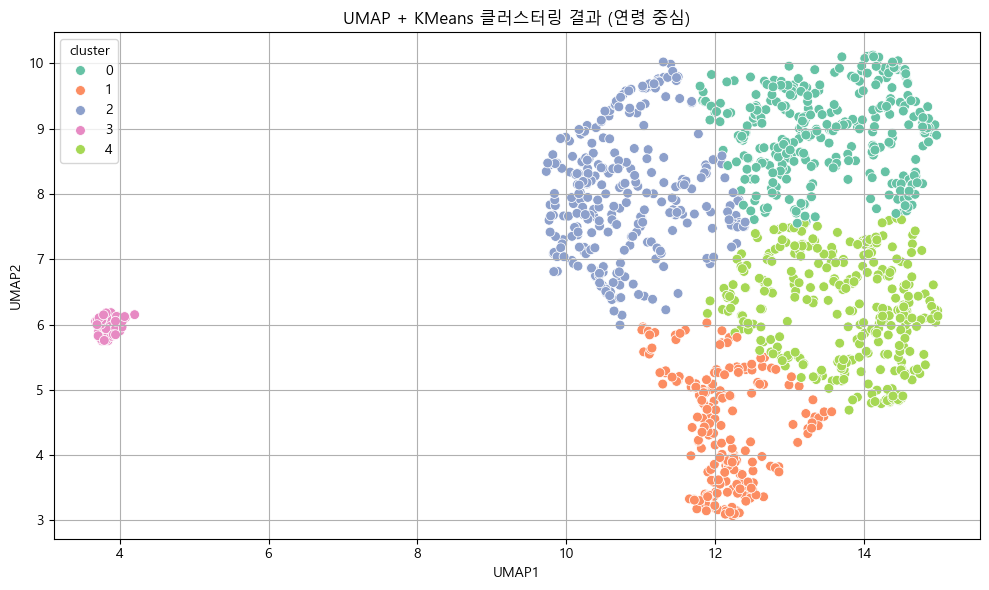

📊 클러스터링 성능 요약:


n_clusters  Silhouette Score  Davies-Bouldin Index  \
0           5            0.4728                0.6405   

   Calinski-Harabasz Score                 Note  
0                   2033.6  연령 중심 UMAP + KMeans


📊 클러스터별 요약 통계표:


C:\Users\user\AppData\Local\Temp\ipykernel_2348\3000050657.py:75: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  formatted_summary = cluster_summary.applymap(lambda x: f"{x:,.2f}")


current_age per_capita_income  total_debt credit_score   tx_amount  \
cluster                                                                      
0             44.73         18,467.72   59,447.13       710.85  255,340.43   
1             53.64         27,086.43   55,856.54       710.90  815,485.26   
2             69.20         20,267.60   16,615.80       716.58  403,507.24   
3             54.28         23,809.78        0.00       741.81  474,269.55   
4             46.14         26,763.39  105,179.80       709.21  527,629.88   

          tx_count online_tx_ratio tx_term income_to_debt_ratio  \
cluster                                                           
0         6,845.51            0.08    9.35                 0.44   
1        17,279.61            0.27    3.81                94.28   
2        10,253.81            0.06    6.67               107.01   
3        11,141.10            0.08    5.95            23,809.78   
4        11,652.34            0.07    5.49                 0.29   

        tx_amount_per_lifetime debt_to_credit_ratio  
cluster                                              
0                        75.40                84.74  
1                       231.12                79.89  
2                       112.83                23.32  
3                       135.17                 0.00  
4                       151.26               149.99


📌 클러스터별 샘플 수:
cluster
0    332
1    208
2    288
3     58
4    315
Name: count, dtype: int64


In [13]:
# 1. 데이터 로딩
df = pd.read_csv("clustering_filtered.csv")
df['total_debt'] = df['total_debt'].fillna(df['total_debt'].mean())

# 2. 파생 변수 생성
df['income_to_debt_ratio'] = df['per_capita_income'] / (df['total_debt'] + 1)
df['tx_amount_per_lifetime'] = df['tx_amount'] / (df['lifetime'] + 1)
df['debt_to_credit_ratio'] = df['total_debt'] / (df['credit_score'] + 1)

# 3. 연령 중심 + 주요 변수 선택
selected_columns = [
    'current_age',
    'per_capita_income',
    'total_debt',
    'credit_score',
    'tx_amount',
    'tx_count',
    'online_tx_ratio',
    'tx_term',
    'income_to_debt_ratio',
    'tx_amount_per_lifetime',
    'debt_to_credit_ratio'
]
df_selected = df[selected_columns].copy()

# 4. 정규화
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_selected)

# 5. UMAP 차원 축소
reducer = umap.UMAP(n_components=2, n_neighbors=47, min_dist=0.0, random_state=42)
X_umap = reducer.fit_transform(X_scaled)

# 6. KMeans 클러스터링
kmeans = KMeans(n_clusters=5, init='random', random_state=42, n_init=10, max_iter=700)
labels = kmeans.fit_predict(X_umap)
df_selected['cluster'] = labels

# 7. 시각화
df_umap = pd.DataFrame(X_umap, columns=['UMAP1', 'UMAP2'])
df_umap['cluster'] = labels
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_umap, x='UMAP1', y='UMAP2', hue='cluster', palette='Set2', s=50)
plt.title("UMAP + KMeans 클러스터링 결과 (연령 중심)")
plt.grid(True)
plt.tight_layout()
plt.show()

# 8. 성능 지표 출력
sil_score = silhouette_score(X_umap, labels)
ch_score = calinski_harabasz_score(X_umap, labels)
db_score = davies_bouldin_score(X_umap, labels)

results_df = pd.DataFrame([{
    "n_clusters": 5,
    "Silhouette Score": round(sil_score, 4),
    "Davies-Bouldin Index": round(db_score, 4),
    "Calinski-Harabasz Score": round(ch_score, 2),
    "Note": "연령 중심 UMAP + KMeans"
}])
print("클러스터링 성능 요약:")
display(results_df)

# 9. 클러스터별 통계 요약
cluster_summary = df_selected.groupby('cluster').mean(numeric_only=True)
formatted_summary = cluster_summary.applymap(lambda x: f"{x:,.2f}")
print("\n클러스터별 요약 통계표:")
display(formatted_summary)

# 10. 클러스터별 샘플 수
print("\n클러스터별 샘플 수:")
print(df_selected['cluster'].value_counts().sort_index())

| 클러스터          | 주요 특성 요약                                     | 고객군 해석                                                                        |
| ------------- | -------------------------------------------- | ----------------------------------------------------------------------------- |
| **Cluster 0** | 40대 중반, 소득·부채 낮음, 소비 적음, 온라인 이용률 평균, 거래 기간 김 | **젊은 일반 소비자**<br>기본적인 소비 성향을 가진 중산층 고객으로, 리스크 적고 활동 기간이 길어 **충성 고객 유도 전략** 적합 |
| **Cluster 1** | 50대 중반, 고소득·중간 부채, 소비·거래 활발, 온라인 비율 높음       | **중장년 고소비군**<br>소득과 소비 수준 모두 높고 온라인 사용 비율도 높아 **디지털 전환형 고소비층 마케팅** 타겟으로 적절    |
| **Cluster 2** | 고령층(69세), 부채 낮고 신용 높음, 소비 적정, 거래 지속성 높음      | **은퇴 안정 소비자**<br>부채 부담 낮고 보수적이며 예측 가능한 소비 성향을 가짐. **연금·보험·건강 관련 금융상품 추천 적합**  |
| **Cluster 3** | 50대 중반, 부채 없음, 신용도 가장 높음, 소비 안정적             | **고신용 무부채 고객**<br>재무 건전성 최상위. **VIP 혜택, 프리미엄 금융 서비스 제공군**으로 우선 타겟팅 가능         |
| **Cluster 4** | 40대 중반, 부채 매우 높고 신용 낮음, 소비 매우 많음             | **리스크 소비자**<br>과소비와 과부채가 함께 있는 고위험군. **모니터링 및 리스크 완화 프로그램 필요**, 적극적인 신용 관리 대상 |


# 지역중심 클러스터링

C:\Users\user\anaconda3\envs\clustering_env\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


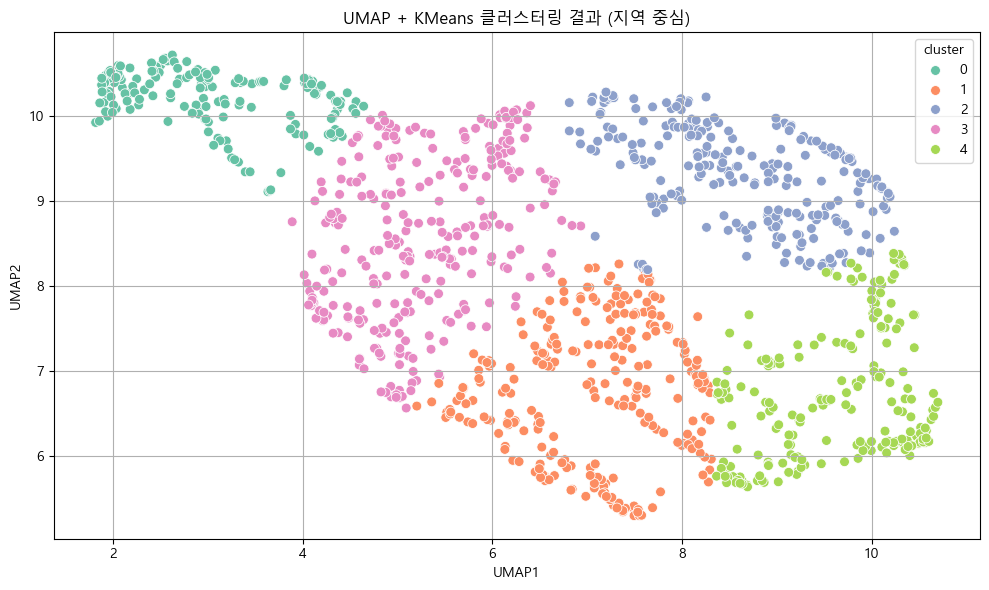

📊 클러스터링 성능 지표 요약:


n_clusters  Silhouette Score  Davies-Bouldin Index  \
0           5            0.4284                0.7657   

   Calinski-Harabasz Score                   Note  
0                  1699.97  UMAP + KMeans (지역 중심)


📊 클러스터별 요약 통계표:


C:\Users\user\AppData\Local\Temp\ipykernel_2348\2940951470.py:82: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  formatted_summary = cluster_summary.applymap(lambda x: f"{x:,.2f}")


region_avg   tx_amount amount_diff_from_region_avg online_tx_ratio  \
cluster                                                                       
0        484,405.71  760,784.05                  276,378.34            0.32   
1        515,320.33  339,809.20                 -175,511.14            0.06   
2        377,993.38  374,849.86                   -3,143.51            0.06   
3        500,500.25  669,814.13                  169,313.88            0.07   
4        437,142.72  232,345.98                 -204,796.74            0.09   

        credit_risk per_capita_income income_vs_region_avg   tx_count tx_term  
cluster                                                                        
0             79.06         24,787.24                 0.05  17,480.54    3.85  
1             67.52         20,507.09                 0.04   9,190.53    6.71  
2             65.13         18,960.35               174.75  10,703.77    5.91  
3            122.76         30,253.40                 0.06  12,942.98    4.97  
4             65.76         18,480.77                 0.04   5,295.14   11.61

In [14]:
# 1. 데이터 로딩
df = pd.read_csv("clustering_filtered.csv")

# 2. 전처리 및 파생 변수 생성
df['total_debt'] = df['total_debt'].fillna(df['total_debt'].mean())

# 파생 변수 추가
df['amount_diff_from_region_avg'] = df['tx_amount'] - df['region_avg']
df['income_vs_region_avg'] = df['per_capita_income'] / (df['region_avg'] + 1)

# 3. 사용할 변수 선택 (지역 중심)
selected_columns = [
    'region_avg',
    'tx_amount',
    'amount_diff_from_region_avg',
    'online_tx_ratio',
    'credit_risk',
    'per_capita_income',
    'income_vs_region_avg',
    'tx_count',
    'tx_term',
]

df_selected = df[selected_columns].copy()

# 4. 정규화
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_selected)

# 5. UMAP 차원 축소
reducer = umap.UMAP(n_components=2, n_neighbors=47, min_dist=0.0, random_state=42)
X_umap = reducer.fit_transform(X_scaled)

# 6. KMeans 클러스터링
kmeans = KMeans(
    n_clusters=5,
    init='random',
    random_state=42,
    n_init=10,
    max_iter=700
)
labels = kmeans.fit_predict(X_umap)
df_selected['cluster'] = labels

# 7. 시각화
df_umap = pd.DataFrame(X_umap, columns=['UMAP1', 'UMAP2'])
df_umap['cluster'] = labels
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_umap, x='UMAP1', y='UMAP2', hue='cluster', palette='Set2', s=50)
plt.title("UMAP + KMeans 클러스터링 결과 (지역 중심)")
plt.grid(True)
plt.tight_layout()
plt.show()

# 8. 성능 지표 계산
sil_score = silhouette_score(X_umap, labels)
ch_score = calinski_harabasz_score(X_umap, labels)
db_score = davies_bouldin_score(X_umap, labels)

# 9. 성능 출력
results_df = pd.DataFrame([{
    "n_clusters": 5,
    "Silhouette Score": round(sil_score, 4),
    "Davies-Bouldin Index": round(db_score, 4),
    "Calinski-Harabasz Score": round(ch_score, 2),
    "Note": "UMAP + KMeans (지역 중심)"
}])
print("클러스터링 성능 지표 요약:")
display(results_df)

# 10. 클러스터별 요약 통계
cluster_summary = df_selected.groupby('cluster').mean(numeric_only=True)
formatted_summary = cluster_summary.applymap(lambda x: f"{x:,.2f}")
print("\n클러스터별 요약 통계표:")
display(formatted_summary)

| 클러스터          | 주요 특성 요약                                                                  | 고객군 해석                                                                   |
| ------------- | ------------------------------------------------------------------------- | ------------------------------------------------------------------------ |
| **Cluster 0** | 소비 금액 가장 높음 (76만), 지역 평균 대비 +27만, 온라인 비중 매우 높음(0.32), 신용도 79, 소득 24,787   | **도시 고소득 적극 소비층**<br>소득 및 지역소비 모두 높은 도시 고객군으로, 디지털 친화적이며 마케팅 반응률이 높을 가능성 |
| **Cluster 1** | 소비 금액 낮음 (33만), 지역 평균 대비 -17만, 온라인 비중 낮음(0.06), 신용도 낮음(67), 소득 낮음(20,507) | **저소득 저소비 보수층**<br>소득/소비/신용 모두 낮고 온라인 이용도도 낮아, 오프라인 기반 프로모션이 적합          |
| **Cluster 2** | 지역 평균 수준 소비 (37만), 차이 거의 없음, 신용도 가장 낮음(65), 거래량은 많음(10,703)               | **지역 평균형 다거래 고객층**<br>중소도시 중심의 일반 고객으로 거래는 활발하나 소비/소득은 평균 수준             |
| **Cluster 3** | 고소득 (30,253), 소비 높음 (66만), 지역 평균 대비 +16만, 신용도 매우 높음(123)                  | **프리미엄 고객군**<br>지역 대비 높은 소득과 소비, 신용도까지 우수 → VIP 등급 마케팅 타깃                |
| **Cluster 4** | 소비 매우 낮음 (23만), 지역 평균보다 -20만 이상, 거래량 적고 tx\_term 가장 김 (11.6), 소득도 낮음      | **소외 또는 비활성 고객층**<br>낮은 소득·소비와 긴 거래 주기를 보이는 비활성 고객으로 리텐션 전략 필요           |
